In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
%matplotlib nbagg

In [43]:
file_name="NaI_Cs137_28cm_30.h5"
data=h5py.File(file_name,"r")
event_data=data["event_data"]
raw_data=np.array(data["raw_data"])
raw_data=np.float32(raw_data)

In [44]:
np.shape(raw_data)

(593697, 2000)

<IPython.core.display.Javascript object>


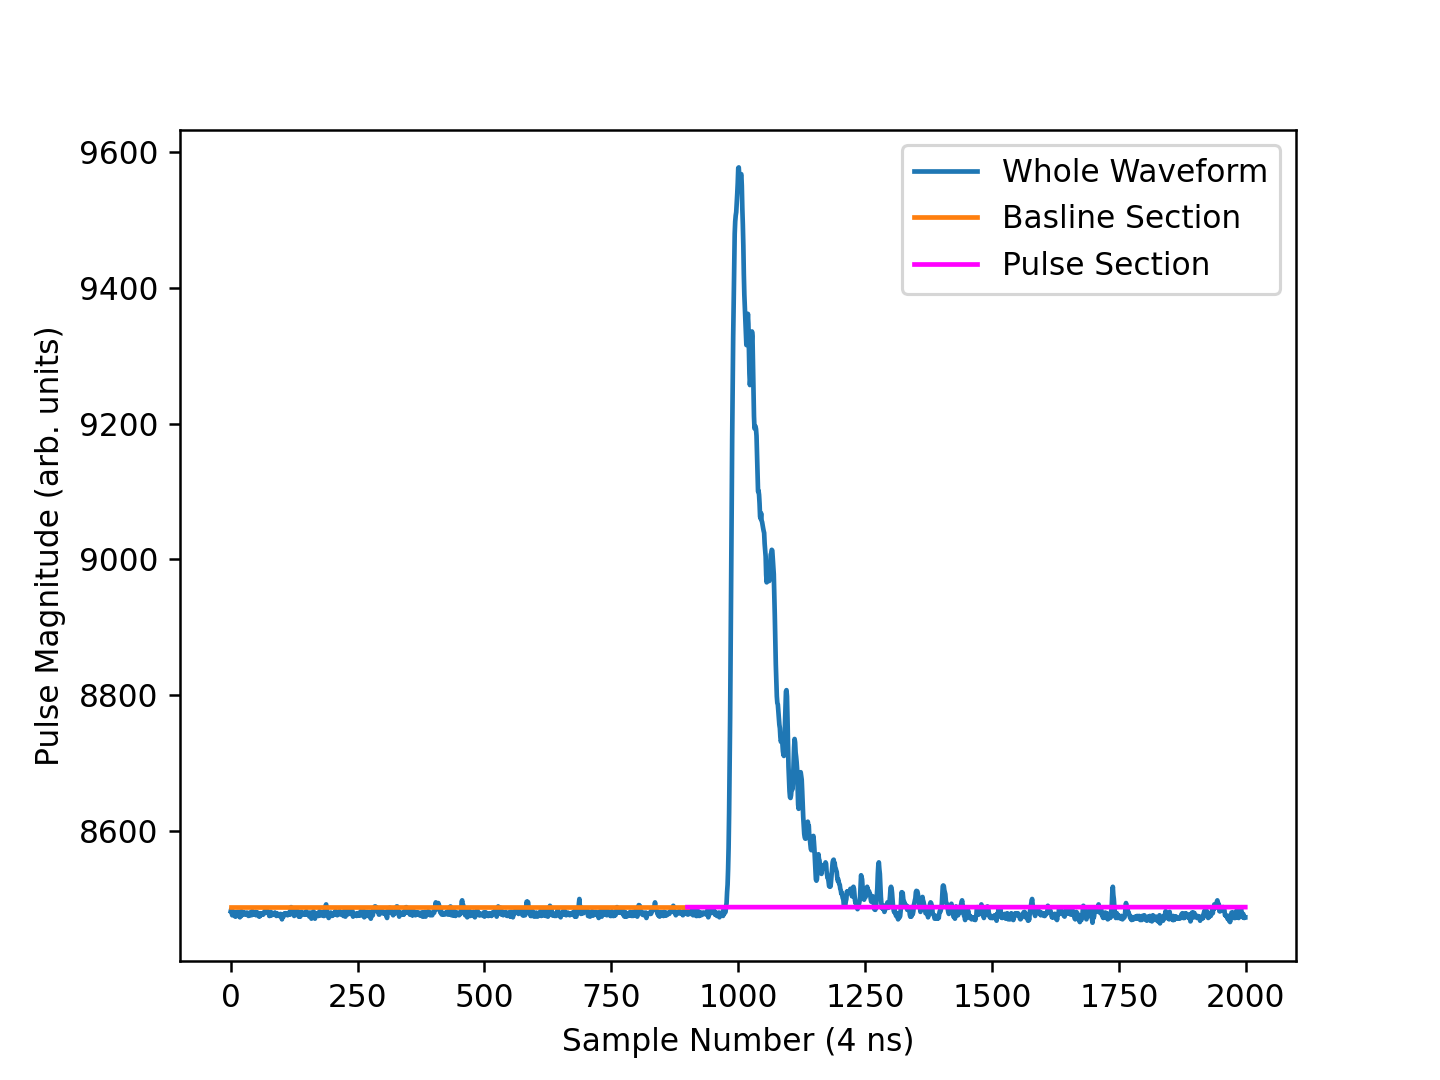

In [45]:
plt.figure("Raw Waveforms")
for i in range(0,1):
    plt.plot(raw_data[i])
plt.xlabel("Sample Number (4 ns)")
plt.ylabel("Pulse Magnitude (arb. units)")
plt.plot(8487*np.ones(900))
plt.plot(np.arange(900,2000),8487*np.ones(1100),color='magenta')
plt.legend(["Whole Waveform","Basline Section","Pulse Section"])

In [46]:
# subtract off baseline
data_to_use=raw_data[0:200000]
baseline=np.mean(data_to_use[:,0:900],axis=1)
bcorrected_data=data_to_use-baseline[:,None]
noise_threshold=np.std(bcorrected_data[:,1500:],axis=1)
bcorrected_data=bcorrected_data[900:]



<IPython.core.display.Javascript object>


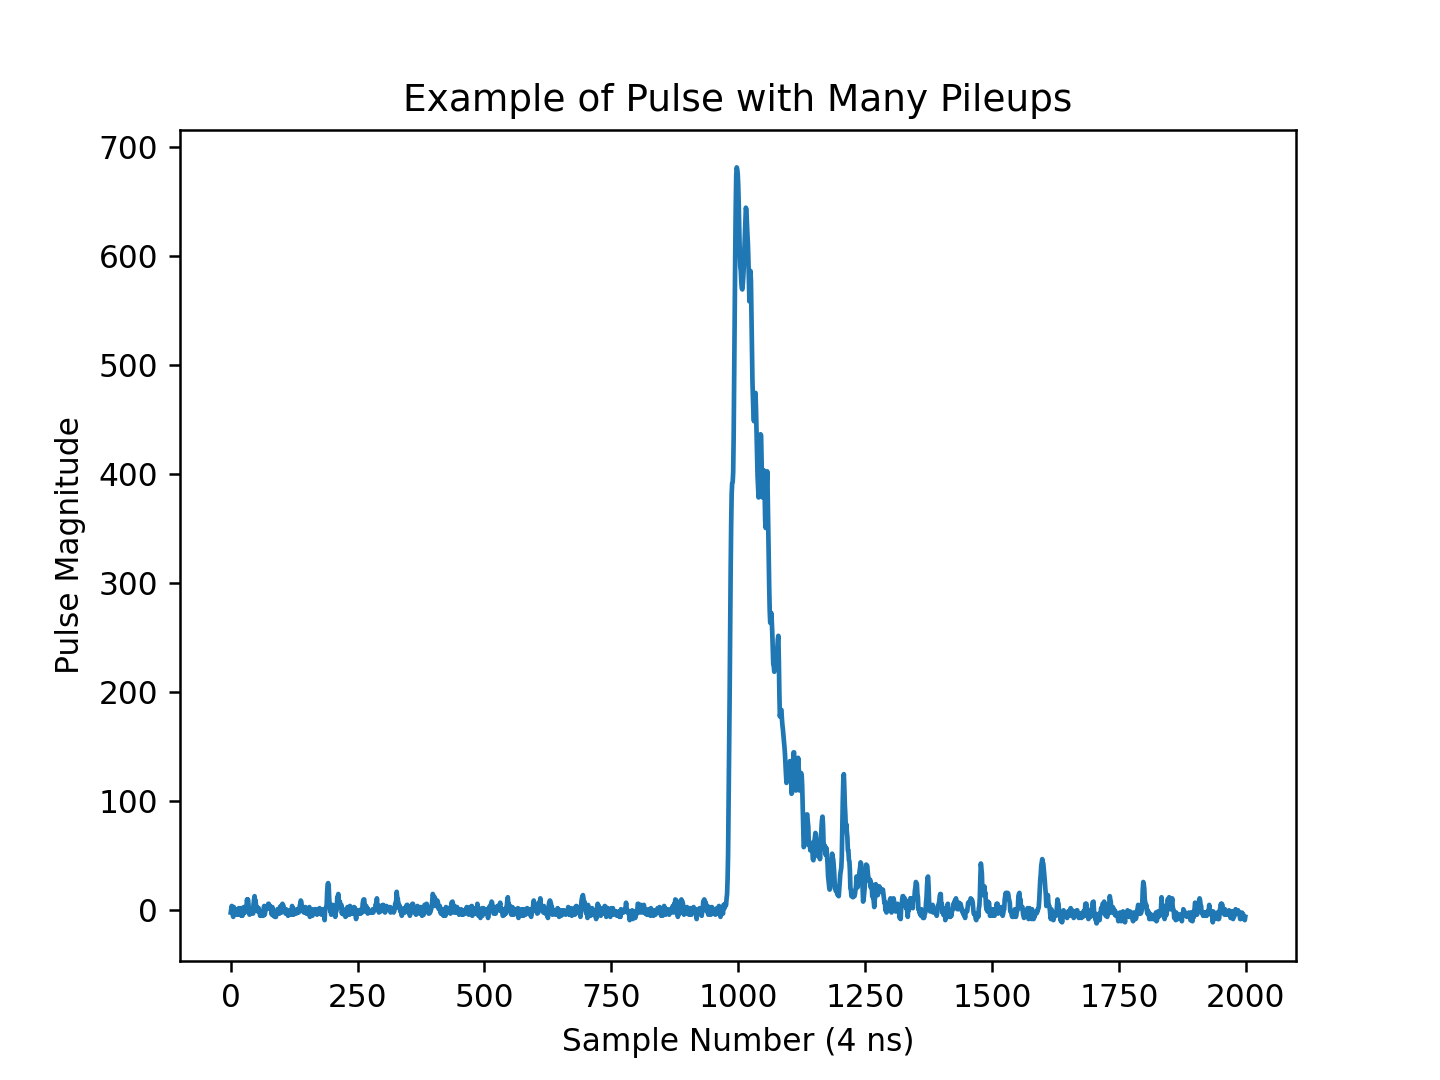

Text(0.5, 1.0, 'Example of Pulse with Many Pileups')

In [47]:
plt.figure("Baseline Corrected Waveform")
plt.plot(bcorrected_data[9462])
plt.xlabel("Sample Number (4 ns)")
plt.ylabel("Pulse Magnitude")
plt.title("Example of Pulse with Many Pileups")

In [48]:
num_peaks=0
pileup_indices=[]
for i in range(0,np.shape(data_to_use)[0]):
    #choose which dataset to use (raw or baseline corrected data)
    waveform=data_to_use[i]
    peaks,prominences=find_peaks(waveform,prominence=250,distance=15)
    if len(peaks)>4:
        pileup_indices.append(i)
    num_peaks=num_peaks+len(peaks)

print(num_peaks)
print((num_peaks-np.shape(data_to_use)[0])/np.shape(data_to_use)[0])
print(pileup_indices)

232160
0.1608
[25003, 90937, 100365, 132006, 151744]


<IPython.core.display.Javascript object>


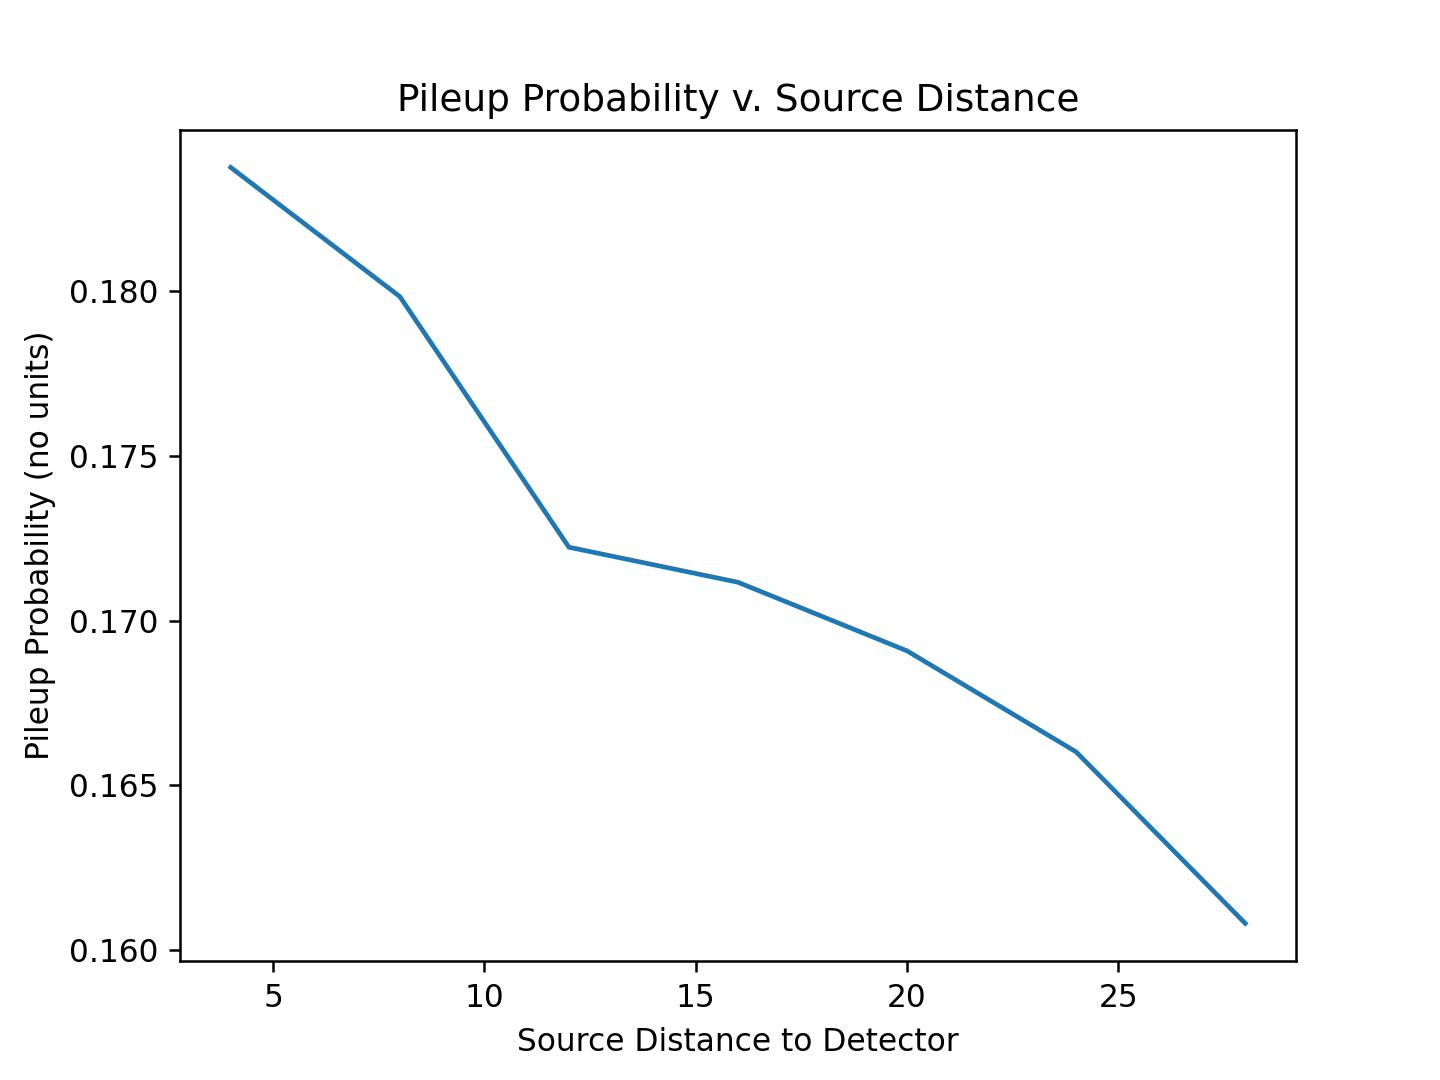

<IPython.core.display.Javascript object>


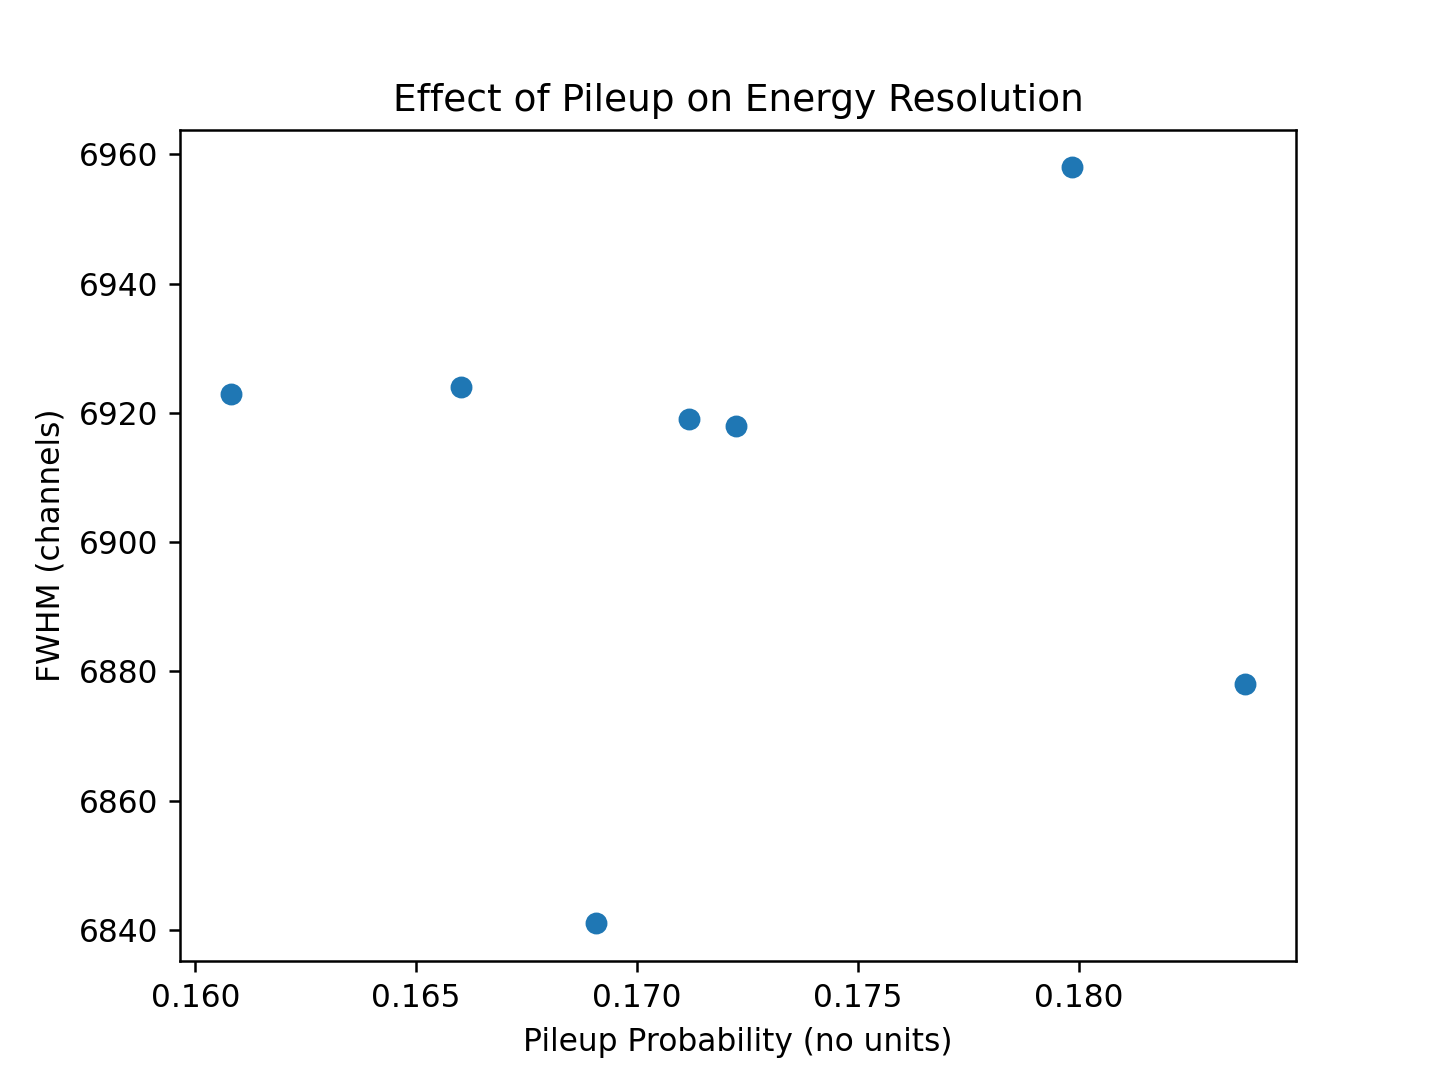

Text(0.5, 1.0, 'Effect of Pileup on Energy Resolution')

In [58]:
d=[4,8,12,16,20,24,28]
pileup_probability_250=[0.18377,0.179845,0.17223,0.171165,0.16908,0.16601,0.1608]
fwhm=[6878,6958,6918,6919,6841,6924,6923]
plt.figure("Pileup Probability")
plt.plot(d,pileup_probability_250)
plt.xlabel("Source Distance to Detector")
plt.ylabel("Pileup Probability (no units)")
plt.title("Pileup Probability v. Source Distance")

plt.figure("Effect of Pileup on Resolution")
plt.scatter(pileup_probability_250,fwhm)
plt.xlabel("Pileup Probability (no units)")
plt.ylabel("FWHM (channels)")
plt.title("Effect of Pileup on Energy Resolution")

In [50]:
channels=np.trapz(bcorrected_data,axis=1)

<IPython.core.display.Javascript object>


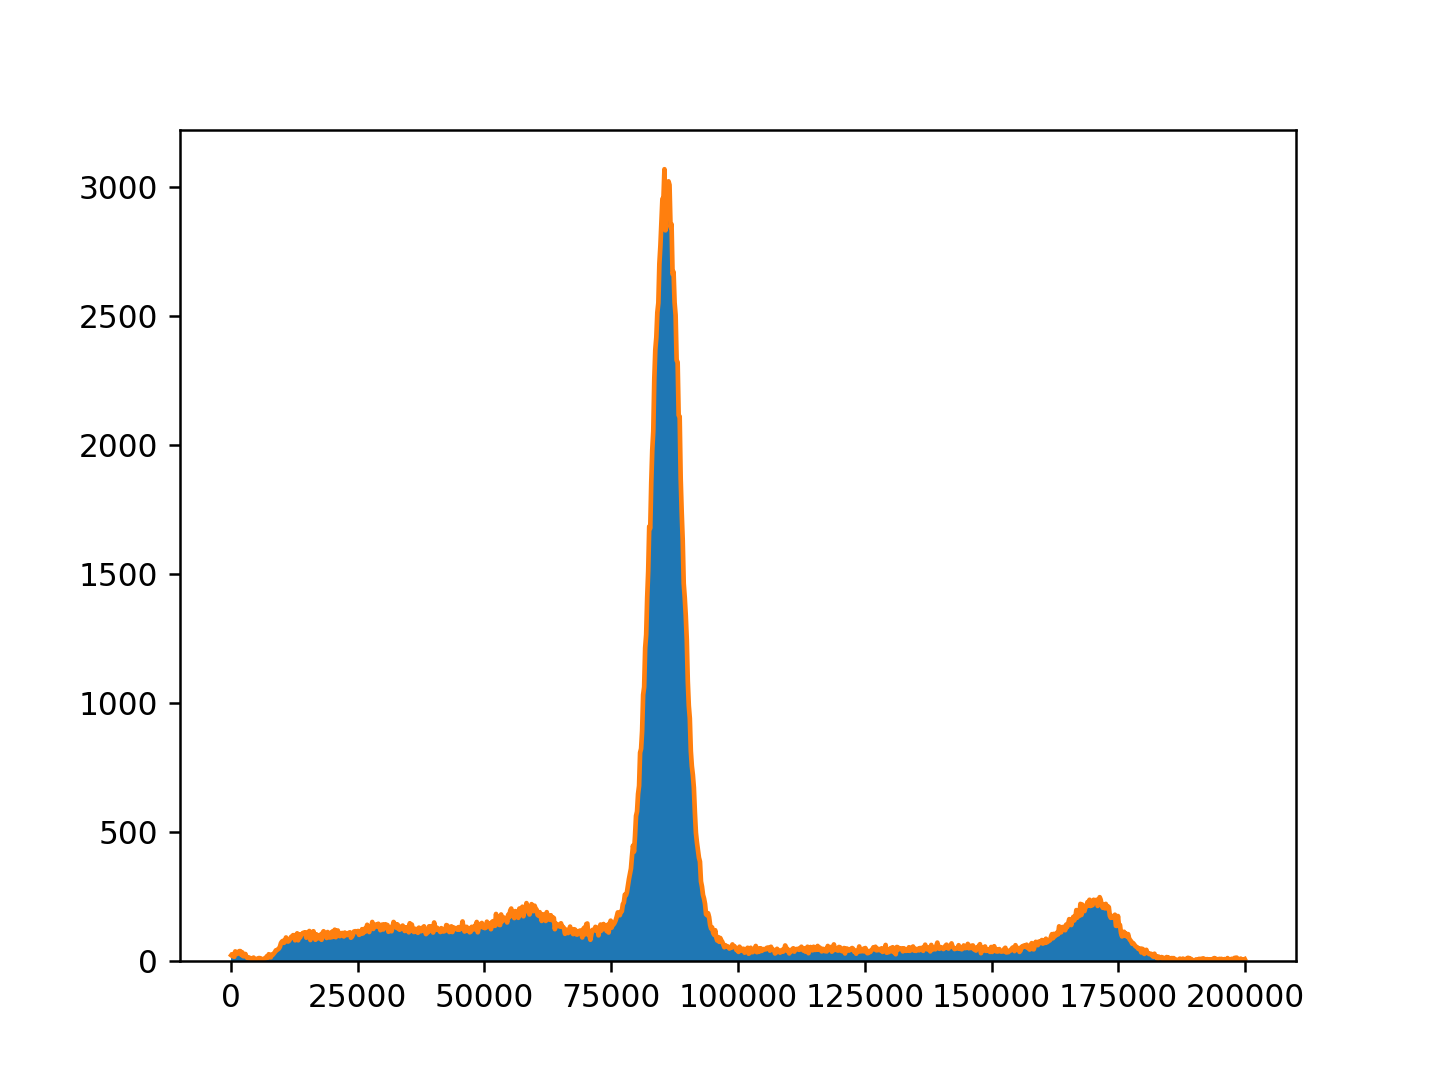

In [51]:
plt.figure("histogram")
histogram=plt.hist(channels,bins=1000,range=[0,200000])
hist_values=histogram[0]
hist_bins=histogram[1]
hist_bins=0.5*(hist_bins[1:]+hist_bins[:-1])
plt.plot(hist_bins,hist_values)
histogram=np.vstack([hist_values,hist_bins])

In [52]:
file_name="Cs137_spectrum.npy"
np.save(file_name,histogram)

In [53]:
Cs137spectrum=np.load("Cs137_spectrum.npy")
Ba133spectrum=np.load("Ba133_spectrum.npy")
Co60spectrum=np.load("Co60_spectrum.npy")

<IPython.core.display.Javascript object>


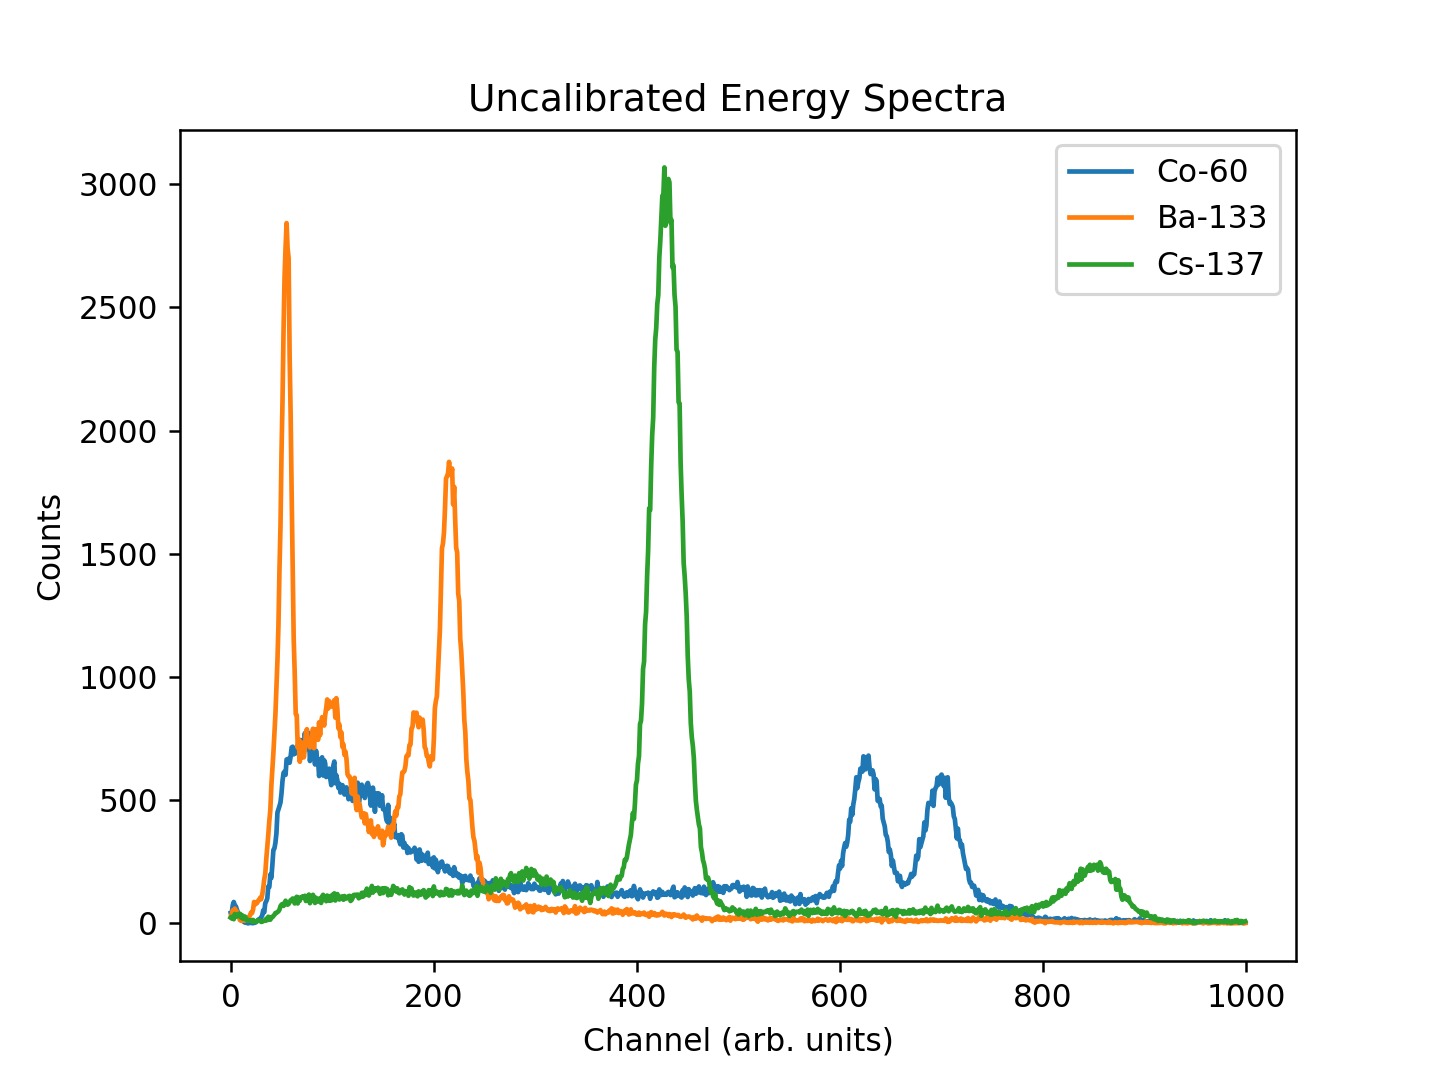

Text(0.5, 1.0, 'Uncalibrated Energy Spectra')

In [54]:
plt.figure("Uncalibrated")
plt.plot(Co60spectrum[0])
plt.plot(Ba133spectrum[0])
plt.plot(Cs137spectrum[0])
plt.legend(["Co-60","Ba-133","Cs-137"])
plt.xlabel("Channel (arb. units)")
plt.ylabel("Counts")
plt.title("Uncalibrated Energy Spectra")

In [41]:
def gauss(x,magnitude, fwhm, mu, slope, constant):
    sigma=fwhm/2.355
    return magnitude/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*(x-mu)**2/sigma**2)+slope*x+constant

<IPython.core.display.Javascript object>


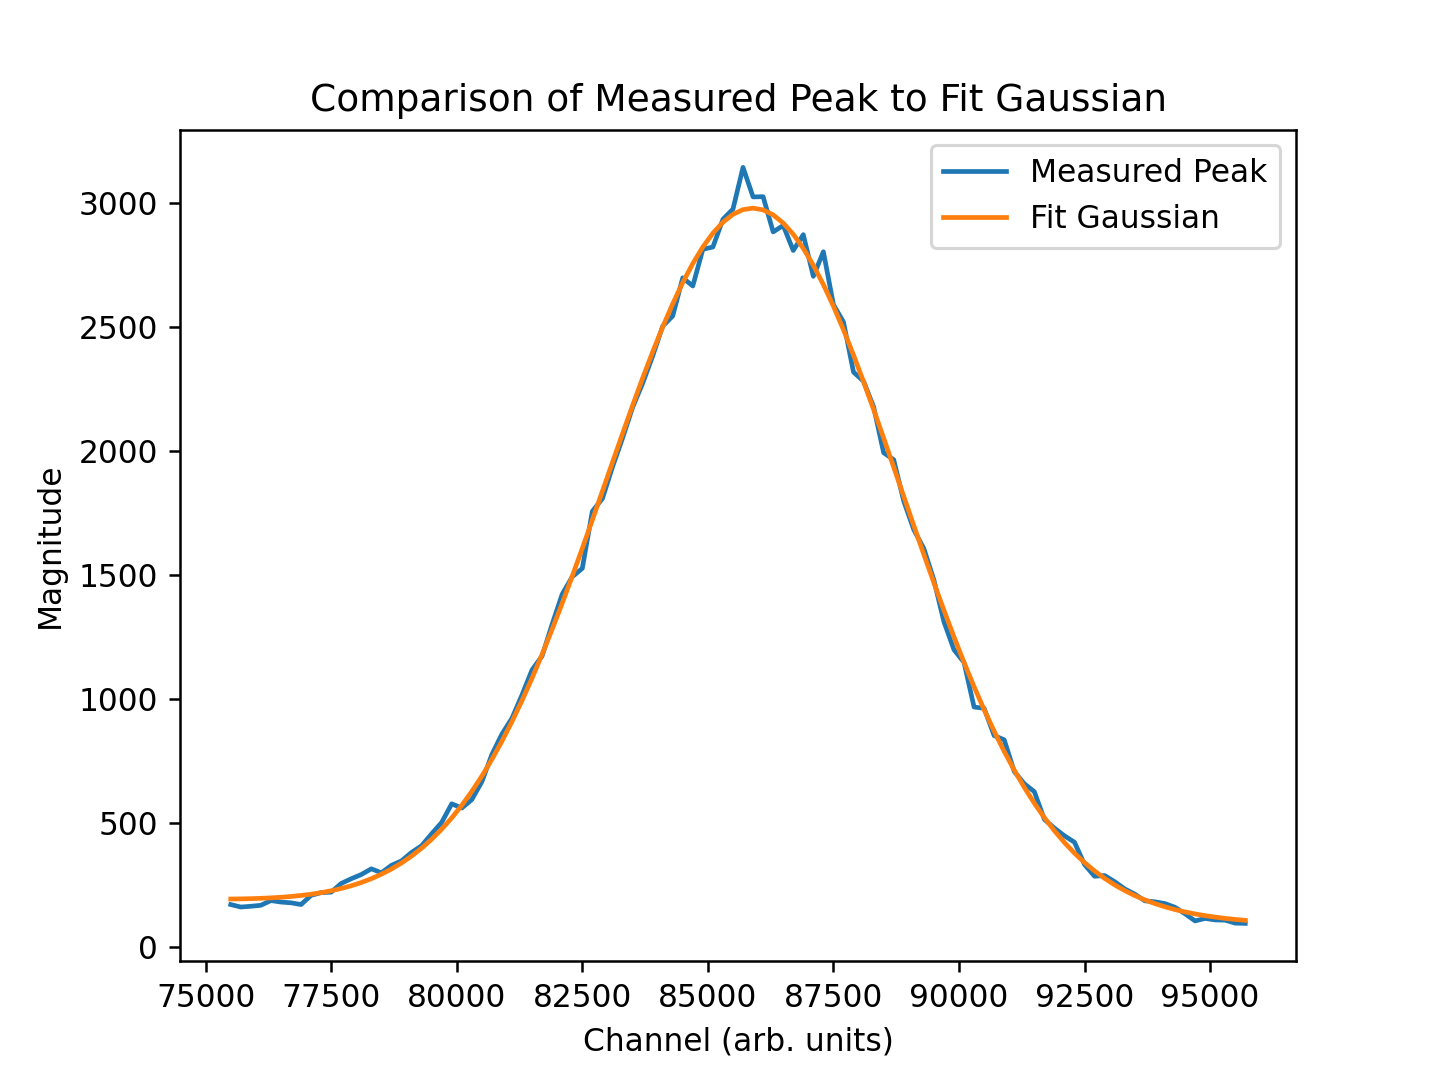

[ 6923.78713141 85905.56369728]
[37.39080268 12.85662603]


In [42]:
histogram=Cs137spectrum[:]
values=histogram[0]
values=values[377:479]
bins=histogram[1]
bins=bins[377:479]
plt.figure("test")
plt.plot(bins,values)


popt,pcov=curve_fit(gauss,bins,values,p0=[700000,5000,86000,-0.01,1000])
plt.plot(bins,gauss(bins,*popt))
print(popt[1:3])
print(np.sqrt(np.diagonal(pcov))[1:3])
plt.xlabel("Channel (arb. units)")
plt.ylabel("Magnitude")
plt.title("Comparison of Measured Peak to Fit Gaussian")
plt.legend(["Measured Peak","Fit Gaussian"])

<IPython.core.display.Javascript object>


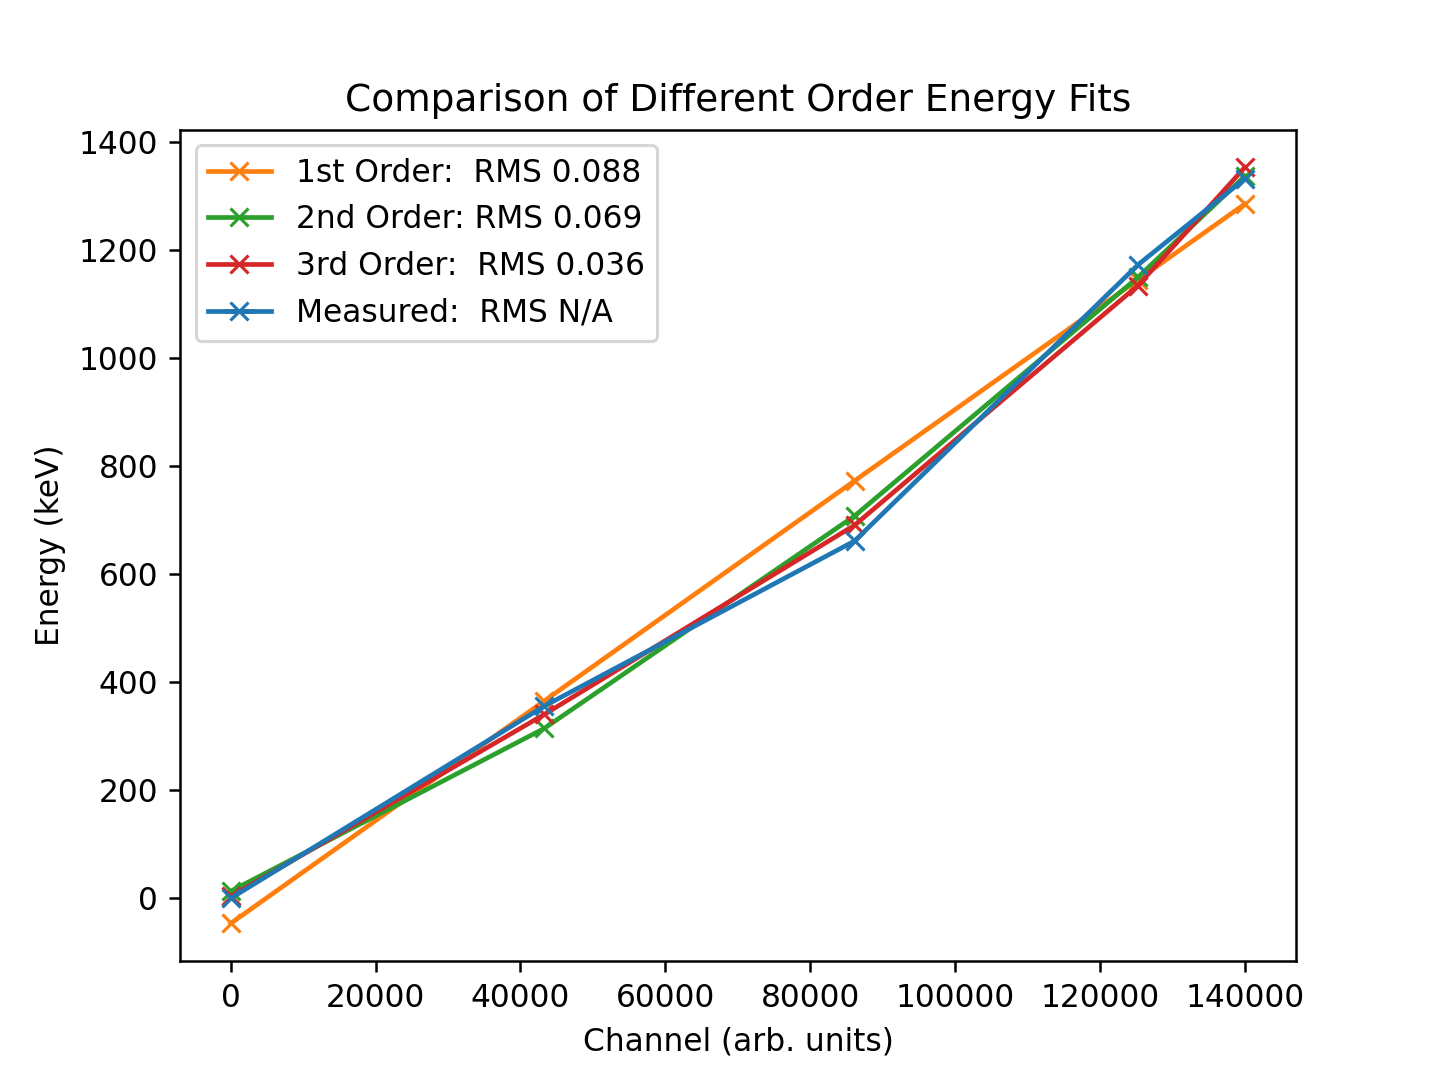

0.0878233604081926 0.06855146289574666 0.035934426413134546
[ 2.71561443e-13 -3.05522198e-08  8.59953075e-03  3.47833972e+00]


Text(0.5, 1.0, 'Comparison of Different Order Energy Fits')

In [183]:

energies=np.array([661.7,356,1173.2,1332.5,0])
sort_indices=np.argsort(energies)
energies=energies[sort_indices]
energies_error=np.array([0,0,0,0,0])[sort_indices]
channels=np.array([86122,43290,125246,139993,0])[sort_indices]
channels_error=np.array([13.8,32.5,42.6,69.5,0])[sort_indices]
channel_fwhm=np.array([6999,4187,7204,7291,0])[sort_indices]
channel_fwhm_error=np.array([38.9,124.8,154,259,0])[sort_indices]
coeff_1=np.polyfit(channels,energies,1)
coeff_2=np.polyfit(channels,energies,2)
coeff_3=np.polyfit(channels,energies,3)

plt.figure("Energy Calib")
plt.errorbar(channels,energies,marker='x',xerr=channels_error)
plt.plot(channels,np.polyval(coeff_1,channels),marker='x')
plt.plot(channels,np.polyval(coeff_2,channels),marker='x')
plt.plot(channels,np.polyval(coeff_3,channels),marker='x')
plt.legend(["1st Order:  RMS 0.088","2nd Order: RMS 0.069","3rd Order:  RMS 0.036","Measured:  RMS N/A"])

diff=np.divide(np.subtract(np.polyval(coeff_1,channels[1:]),energies[1:]),energies[1:])
o1error=np.sqrt(np.mean(np.square(diff)))
diff=np.divide(np.subtract(np.polyval(coeff_2,channels[1:]),energies[1:]),energies[1:])
o2error=np.sqrt(np.mean(np.square(diff)))
diff=np.divide(np.subtract(np.polyval(coeff_3,channels[1:]),energies[1:]),energies[1:])
o3error=np.sqrt(np.mean(np.square(diff)))
print(o1error,o2error,o3error)
print(coeff_3)

plt.xlabel("Channel (arb. units)")
plt.ylabel("Energy (keV)")
plt.title("Comparison of Different Order Energy Fits")
# plt.legend(["Measured: RMS N/A","1st Order:  RMS 0.103","2nd Order: RMS 0.086"])

<IPython.core.display.Javascript object>


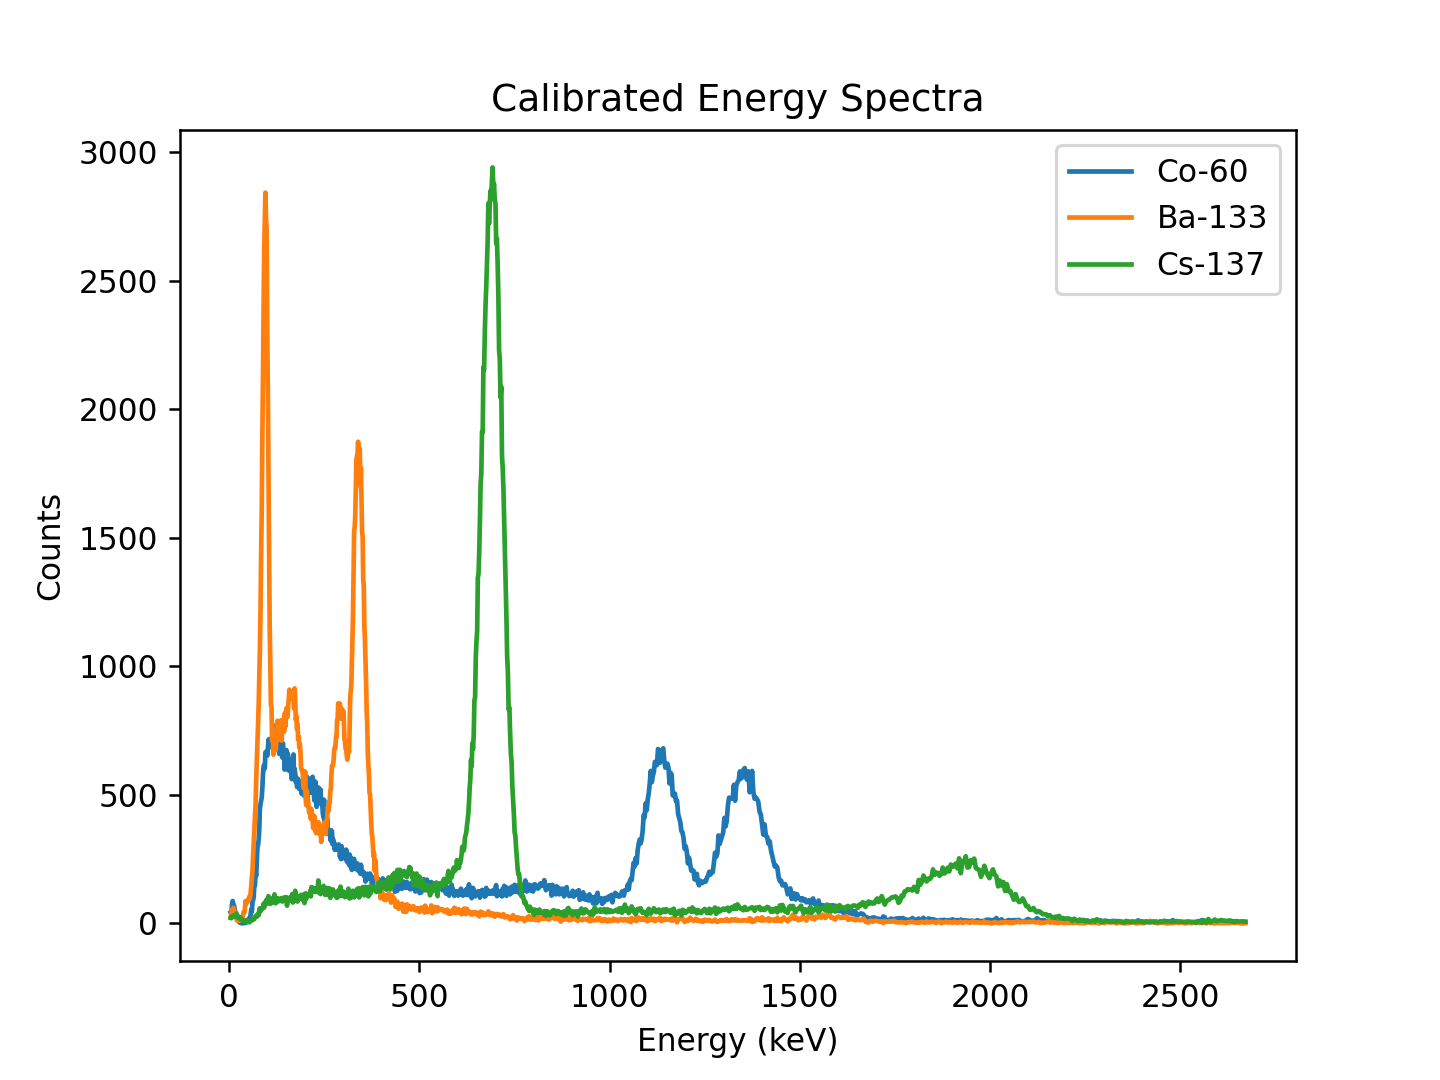

Text(0.5, 1.0, 'Calibrated Energy Spectra')

In [184]:
plt.figure("Calibrated")
plt.plot(np.polyval(coeff_3,Co60spectrum[1]),Co60spectrum[0])
plt.plot(np.polyval(coeff_3,Ba133spectrum[1]),Ba133spectrum[0])
plt.plot(np.polyval(coeff_3,Cs137spectrum[1]),Cs137spectrum[0])
plt.legend(["Co-60","Ba-133","Cs-137"])
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Calibrated Energy Spectra")

<IPython.core.display.Javascript object>


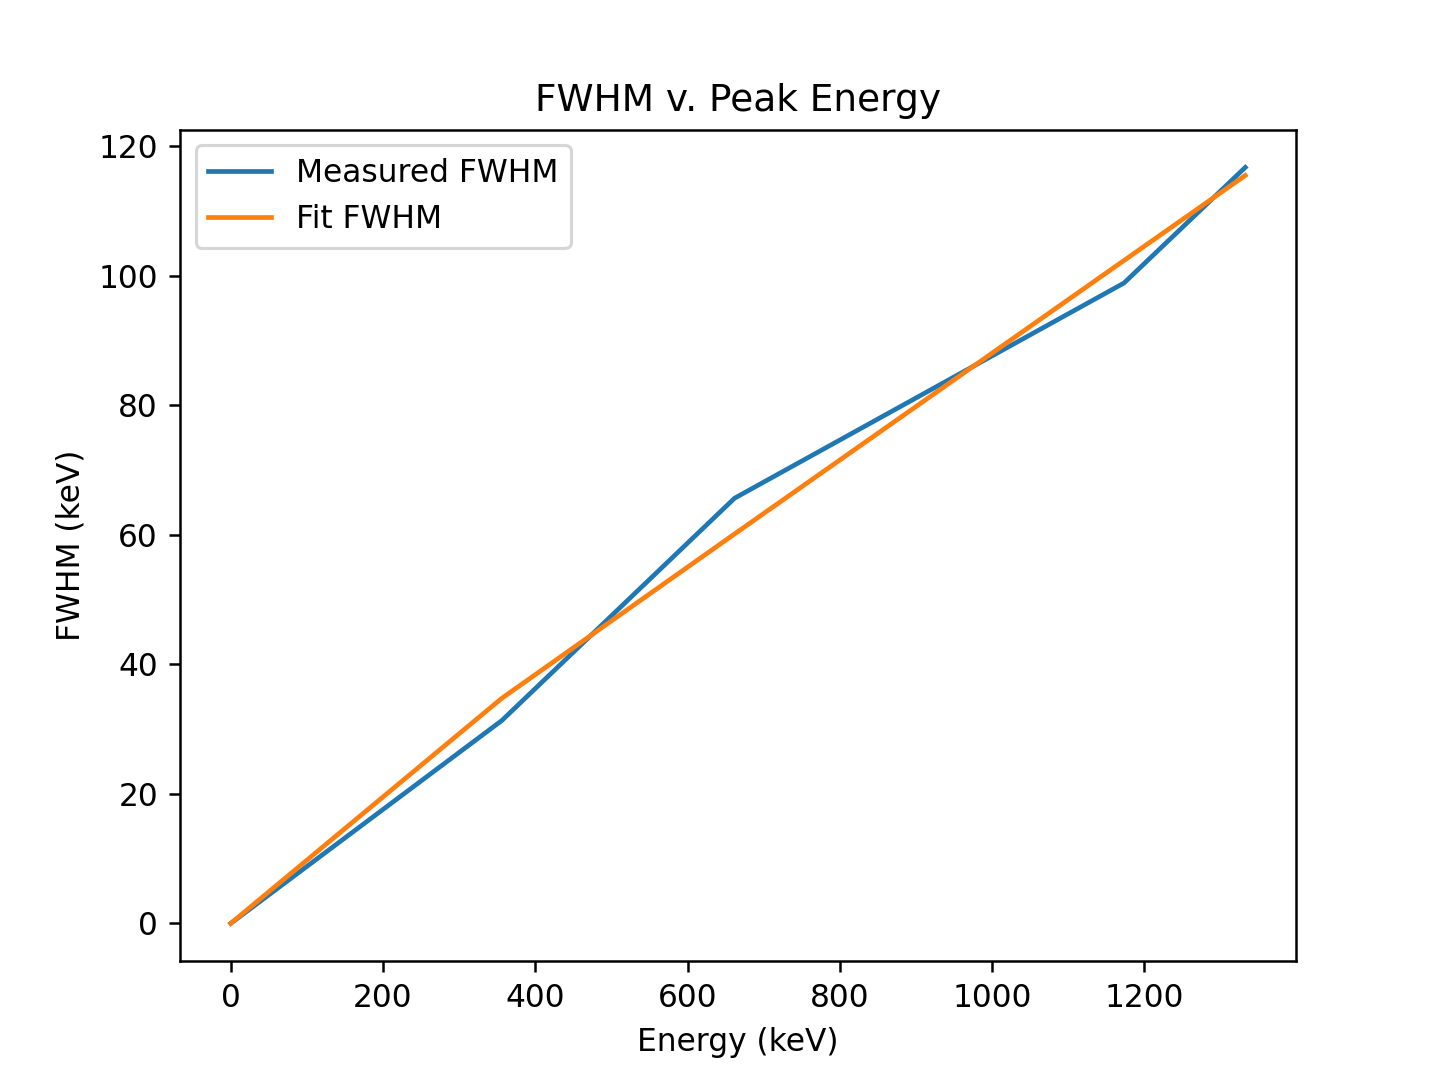

[3.50052117e-08 1.77068060e-01 1.22236051e-03]
0.02631578947368421
6.728586282827564


In [209]:
energy_fwhm=[]
for i in range(0,len(energies)):
    fwhm=channel_fwhm[i]/2
    channel=channels[i]
    energy=energies[i]
    energy_fwhm.append(np.polyval(coeff_3,channel+fwhm)-np.polyval(coeff_3,channel-fwhm))
plt.figure("Resolutions")
plt.plot(energies,energy_fwhm)
plt.xlabel("Energy (keV)")
plt.ylabel("FWHM (keV)")
plt.title("FWHM v. Peak Energy")
def find_fano(E,a,b,c):
    return 2.355*np.sqrt(a+b*E+c*np.square(E))
popt,pcov=curve_fit(find_fano,energies,energy_fwhm,p0=[1,0.01,0.001],bounds=[0,np.inf])
print(popt)
plt.plot(energies,find_fano(energies,*popt))
W=1/38
print(W)
print(popt[1]/W)
plt.legend(["Measured FWHM","Fit FWHM"])

In [ ]:
num_peaks=0
for i in range(0,np.shape(data_to_use)[0]):
    #choose which dataset to use (raw or baseline corrected data)
    waveform=data_to_use[i]
    peaks,prominences=find_peaks(waveform,prominence=150)
#     if len(peaks)>0:
#         num_peaks=num_peaks+1
    num_peaks=num_peaks+len(peaks)

print(num_peaks)
print((num_peaks-np.shape(data_to_use)[0])/np.shape(data_to_use)[0])

In [7]:
#apply threshold
threshold=250
mask=np.any(bcorrected_data>threshold,axis=1)
print(np.shape(bcorrected_data))
threshold_data=bcorrected_data[mask]
print(np.shape(threshold_data))

(199100, 2000)
(139055, 2000)


<IPython.core.display.Javascript object>


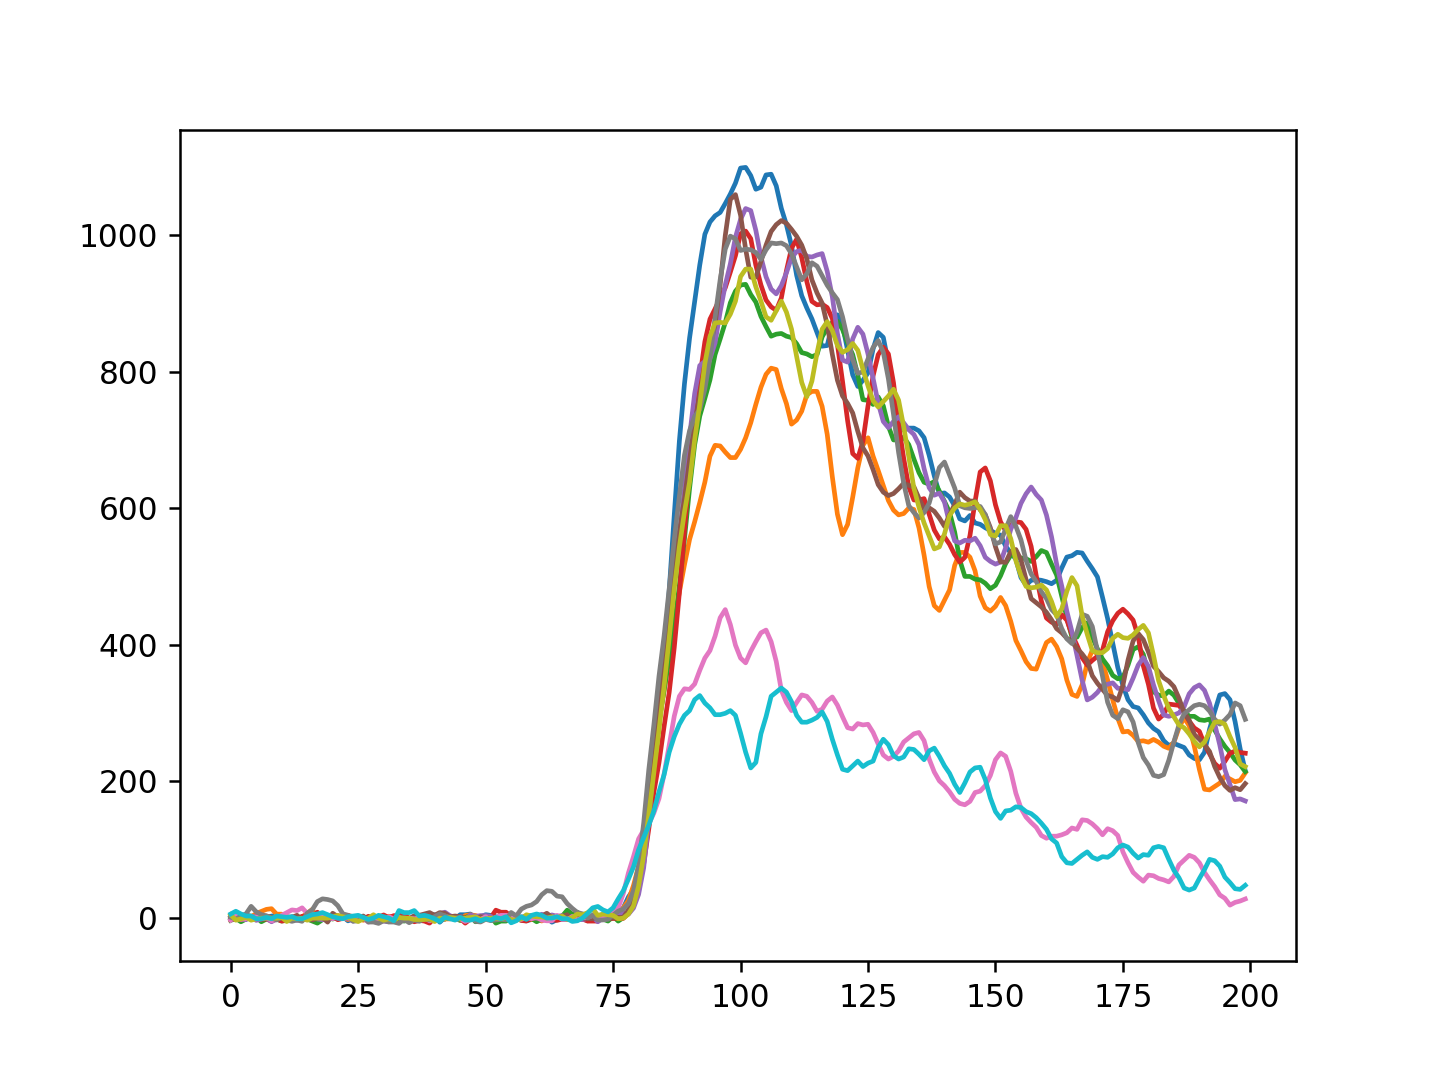

In [6]:
plt.figure('many waveforms')
for i in range(0,10):
    plt.plot(threshold_data[i,900:1100])

In [111]:
cut_data=threshold_data[:,900:1100]
print(np.shape(cut_data))

(579627, 200)


<IPython.core.display.Javascript object>


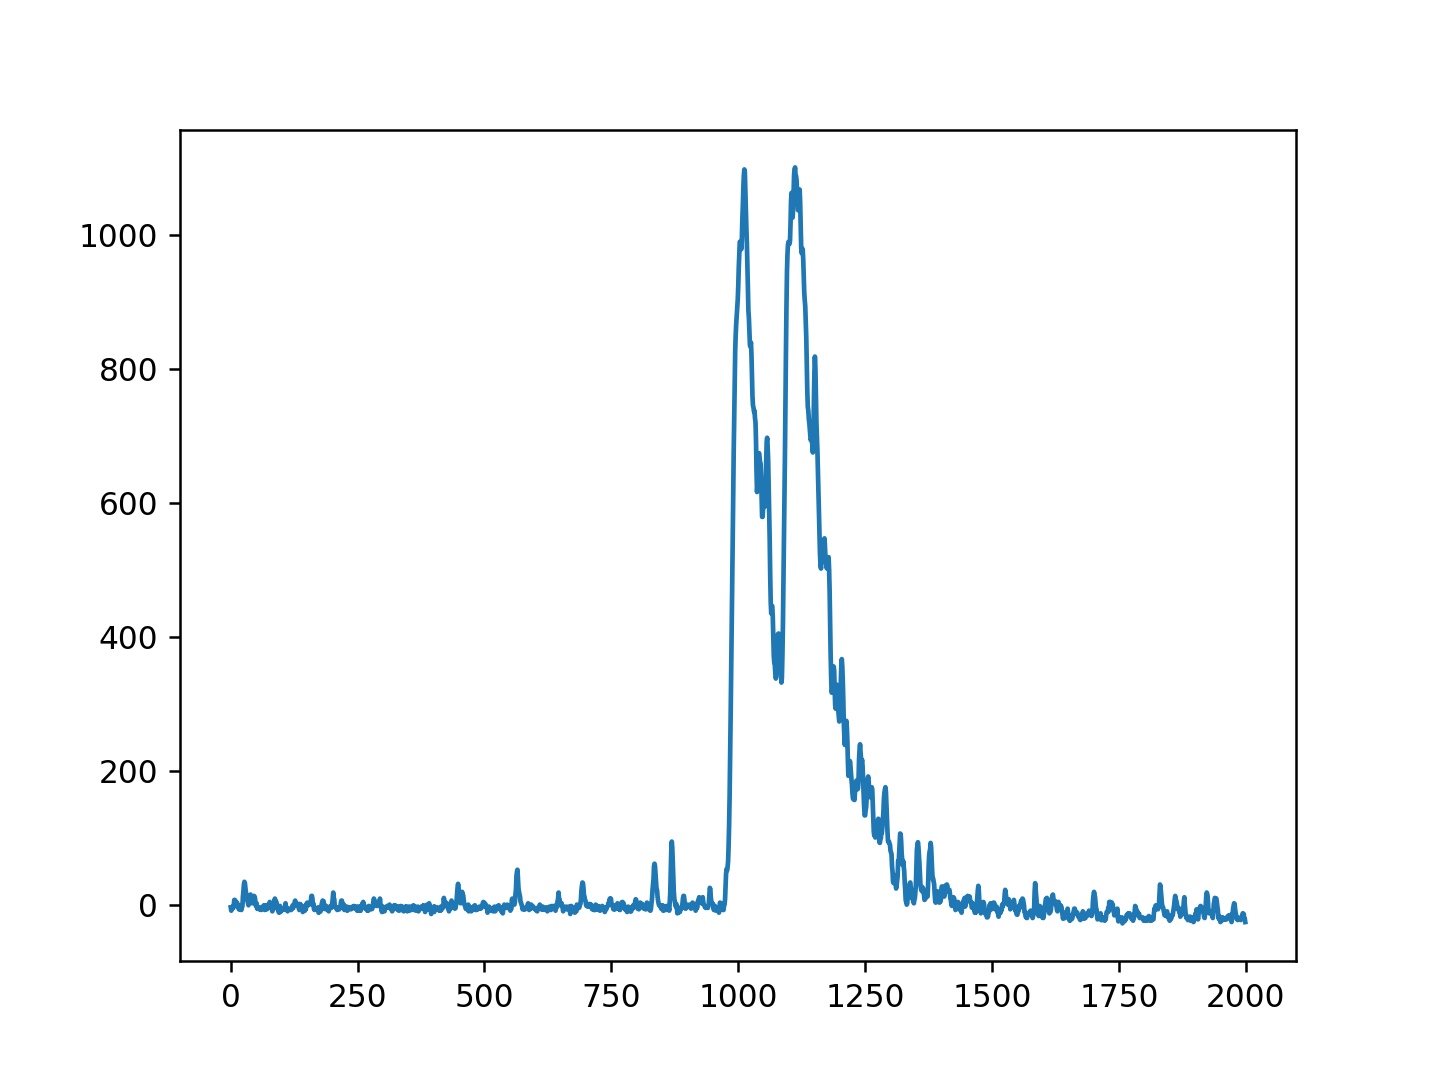

In [112]:
#waveform test plots
plt.figure ("Waveforms")
# for i in range(0,50):
plt.plot(threshold_data[76])

In [113]:
# choose which dataset to look at
data_to_use=cut_data[0:100000]
print(np.shape(data_to_use))

(100000, 200)


In [114]:
# estimate pileup probability

num_peaks=0
for i in range(0,np.shape(data_to_use)[0]):
    #choose which dataset to use (raw or baseline corrected data)
    waveform=data_to_use[i]
    peaks,prominences=find_peaks(waveform,prominence=150)
#     if len(peaks)>0:
#         num_peaks=num_peaks+1
    num_peaks=num_peaks+len(peaks)

print(num_peaks)
print((num_peaks-np.shape(data_to_use)[0])/np.shape(data_to_use)[0])

115754
0.15754


C:\Users\oscma\AppData\Local\Temp\ipykernel_8056\584647313.py:11: RuntimeWarning: invalid value encountered in log
  samples=np.log(samples)
C:\Users\oscma\anaconda3\lib\site-packages\numpy\lib\polynomial.py:659: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
C:\Users\oscma\AppData\Local\Temp\ipykernel_8056\584647313.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  dc[i]=-1/coeff


<IPython.core.display.Javascript object>


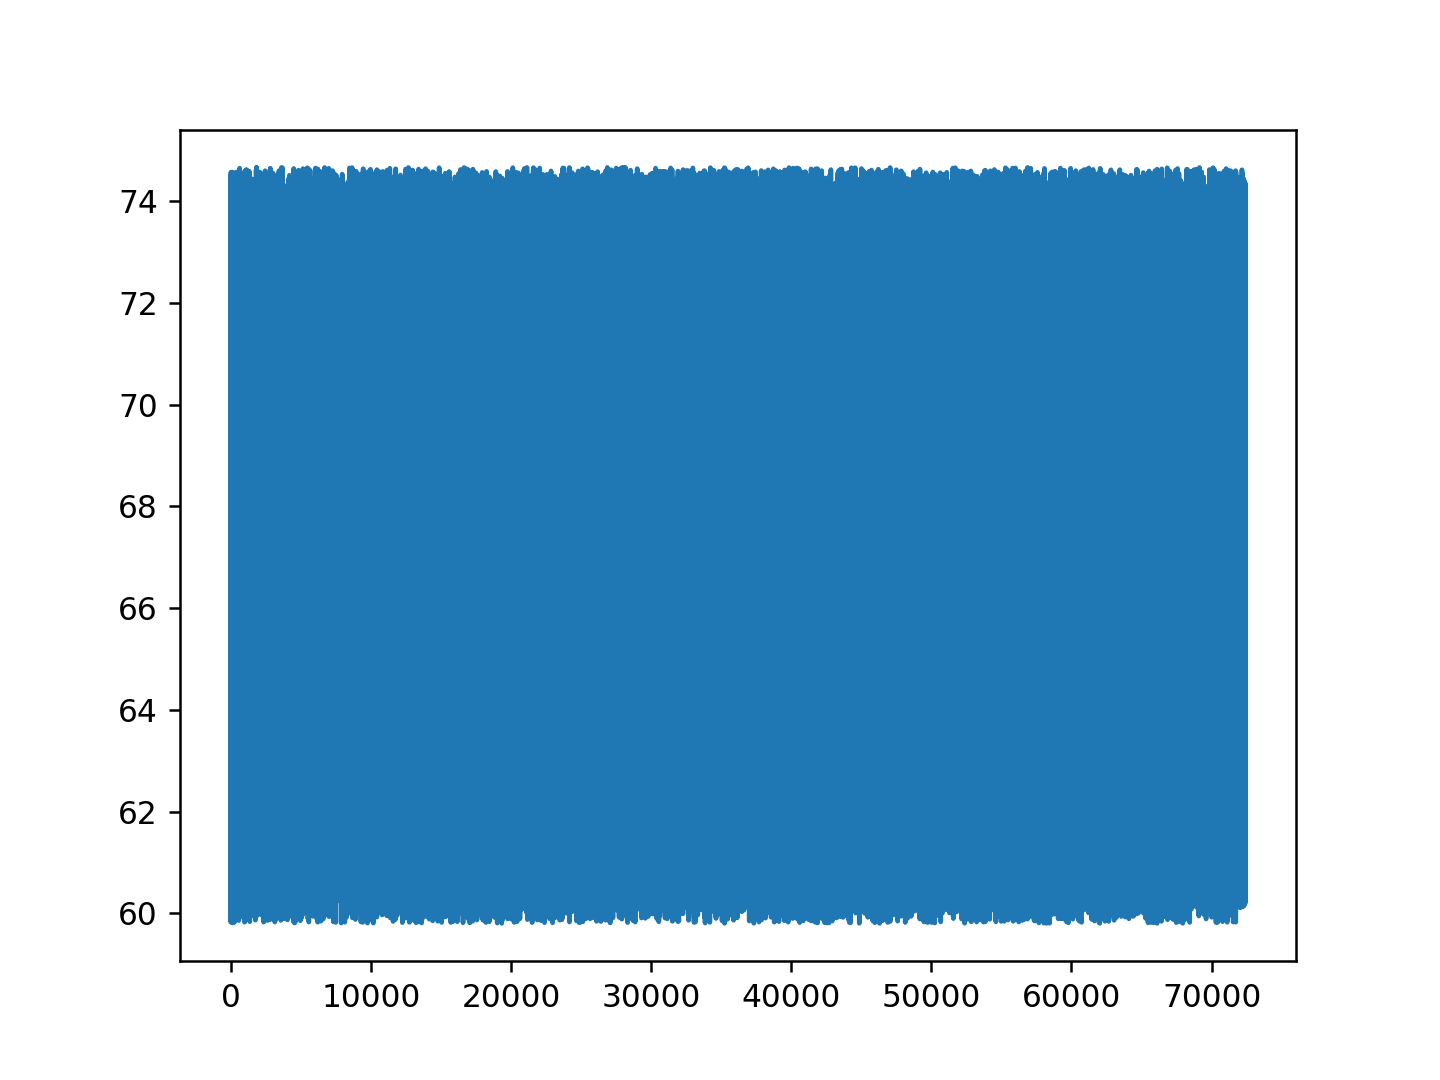

[61.41017427 61.59585523 68.81063536 ... 69.98936261 62.07630519
 68.17477357]
465


In [115]:
# get decay constants
max_indices=np.argmax(data_to_use,axis=1)
dc=np.zeros(np.shape(data_to_use)[0])
fail_count=0
for i in range(0,np.shape(data_to_use)[0]):
    waveform_to_sample=data_to_use[i][max_indices[i]:max_indices[i]+100]
    waveform_to_sample=waveform_to_sample/np.max(waveform_to_sample)
    sample_indices=np.random.choice(np.size(waveform_to_sample),50,replace=True)
    sample_indices=np.sort(sample_indices)
    samples=waveform_to_sample[sample_indices]
    samples=np.log(samples)
    try:
        coeff=np.polyfit(sample_indices,samples,1)[0]
        dc[i]=-1/coeff
    except:
        dc[i]=np.inf
        fail_count+=1

    
mask=dc!=np.inf
data_to_use=data_to_use[mask]
dc=dc[mask]
mask=dc!=-np.inf
data_to_use=data_to_use[mask]
dc=dc[mask]


dc_std=np.std(dc)
dc_mean=np.mean(dc)
mask=dc>dc_mean-dc_std
data_to_use=data_to_use[mask]
dc=dc[mask]
mask=dc<dc_mean+dc_std
data_to_use=data_to_use[mask]
dc=dc[mask]

dc_std=np.std(dc)
dc_mean=np.mean(dc)
mask=dc>dc_mean-dc_std
data_to_use=data_to_use[mask]
dc=dc[mask]
mask=dc<dc_mean+dc_std
data_to_use=data_to_use[mask]
dc=dc[mask]
    
plt.figure("test")
plt.plot(dc)
print(dc)
print(fail_count)

<IPython.core.display.Javascript object>


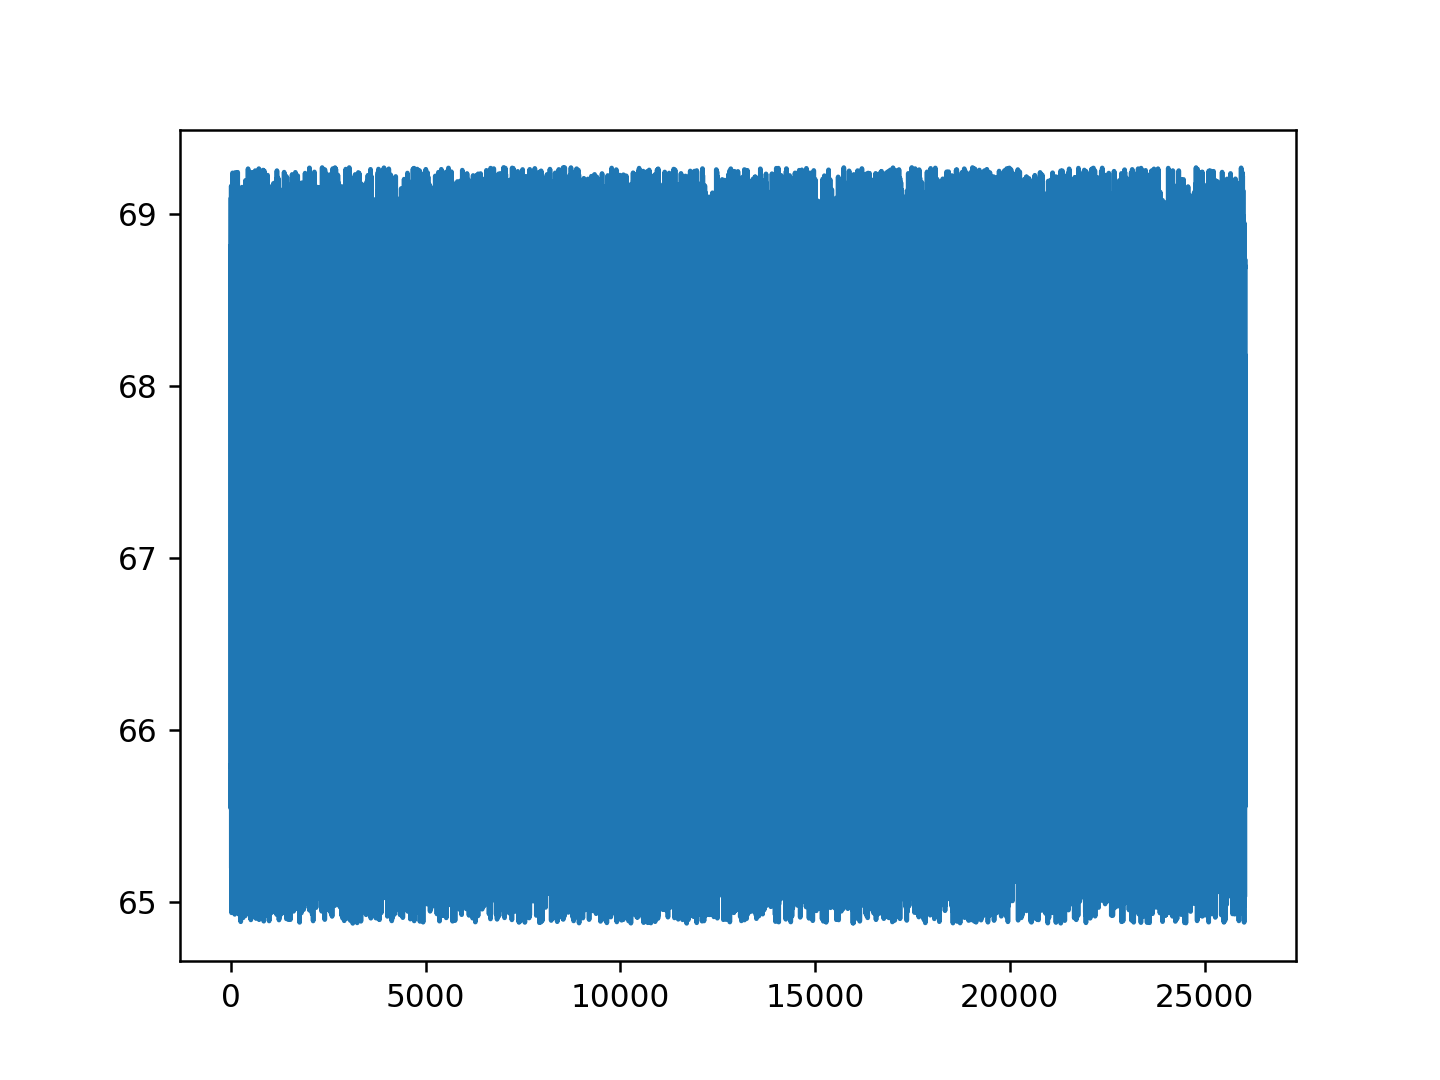

[68.81063536 67.08494992 68.47448054 ... 65.55368932 66.2520349
 68.17477357]
67.07390351926848 2.1991780777159313


In [116]:
dc_std=np.std(dc)
dc_mean=np.mean(dc)
dc_test=dc[:]
mask=dc_test>dc_mean-dc_std
dc_test=dc_test[mask]
mask=dc_test<dc_mean+dc_std
dc_test=dc_test[mask]

dc_std=np.std(dc_test)
dc_mean=np.mean(dc_test)
mask=dc_test>dc_mean-dc_std
dc_test=dc_test[mask]
mask=dc_test<dc_mean+dc_std
dc_test=dc_test[mask]

plt.figure("dc")
plt.plot(dc_test)
print(dc_test)
print(dc_mean,dc_std)

<IPython.core.display.Javascript object>


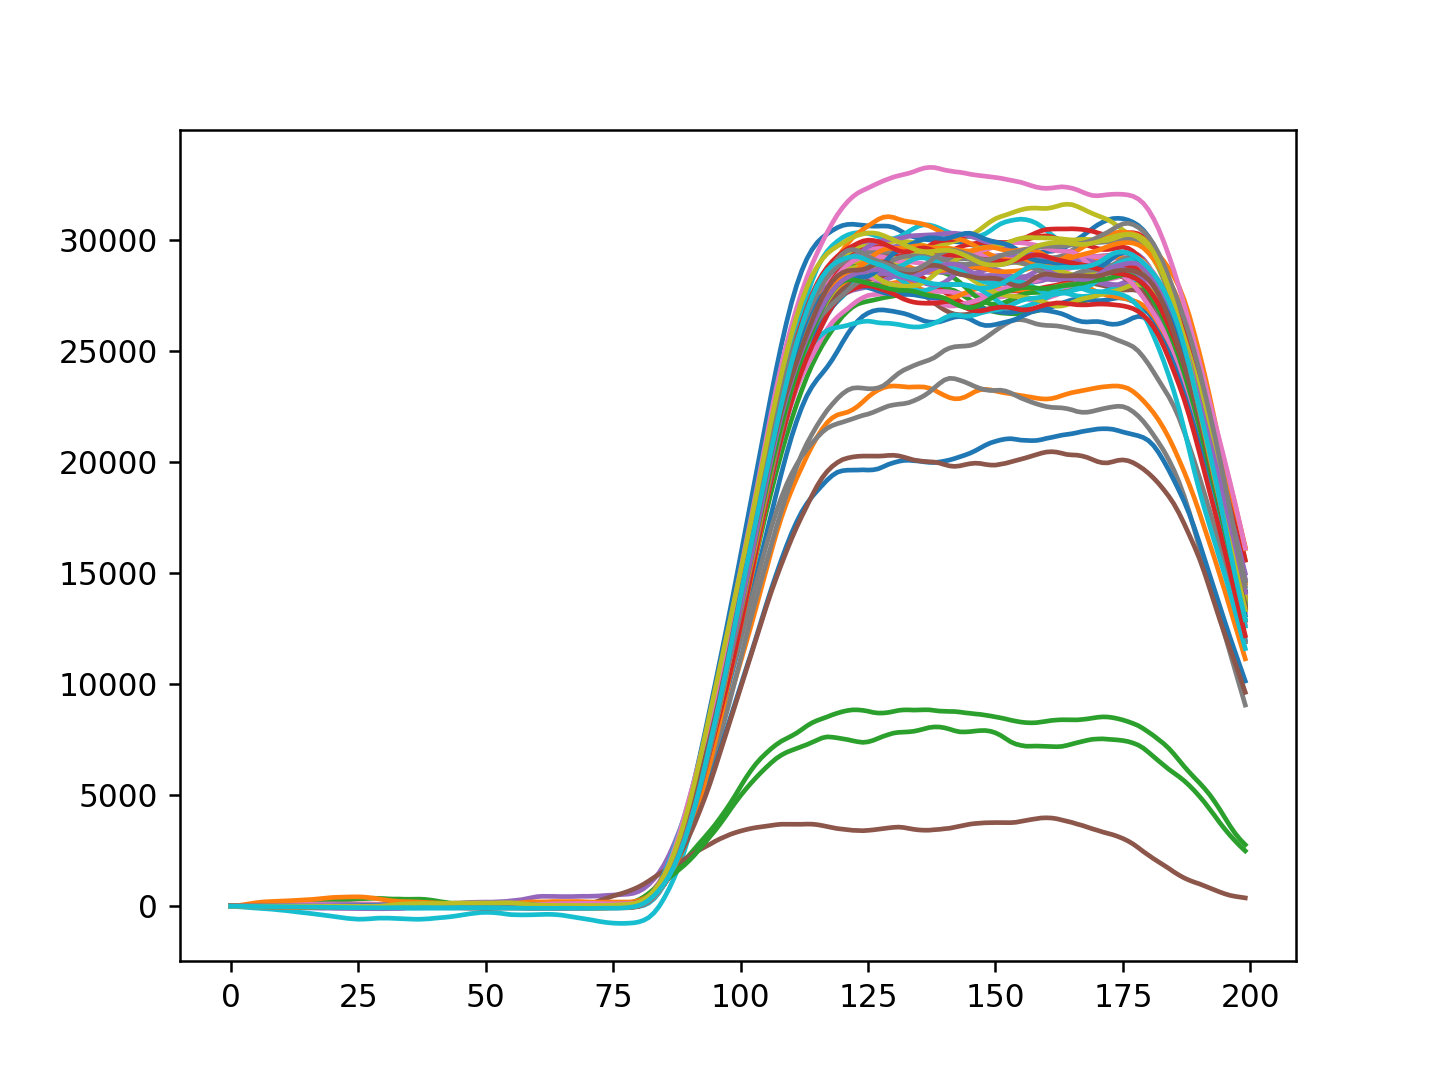

In [129]:
# apply trapezoidal filter

channels=[]

l=96 #flat top plus rise time, flat top: gap time
k=26#int(np.floor(l/3)) #rise time - peaking time

plt.figure("Filter")

for i in range(0,np.shape(data_to_use)[0]):
    filtered_waveform=[]
    waveform=data_to_use[i]
#     for j in range(0,np.size(waveform)):
#         if j<k+l:
#             filtered_waveform.append(0)
#         else:
#             d=waveform[j]-waveform[j-k]-waveform[j-l]+waveform[j-k-l]
#             filtered_waveform.append(filtered_waveform[-1]*(1+1/dc[i])+d)
#     channels.append(np.max(filtered_waveform))
    trapz_waveform=[]
    polezero_waveform=[0]
    for j in range(0,len(waveform)):
        if j<k:
            trapz_waveform.append(waveform[j])
        elif j<l:
            trapz_waveform.append(waveform[j]-waveform[j-k])
        elif j<k+l:
            trapz_waveform.append(waveform[j]-waveform[j-k]-waveform[j-l])
        else:
            trapz_waveform.append(waveform[j]-waveform[j-k]-waveform[j-l]+waveform[j-k-l])

    for j in range(1,len(waveform)):
        polezero_waveform.append(polezero_waveform[j-1]*(1+1/125)+trapz_waveform[j])
    if i<50:
        plt.plot(polezero_waveform)
    channels.append(np.max(polezero_waveform))

<IPython.core.display.Javascript object>


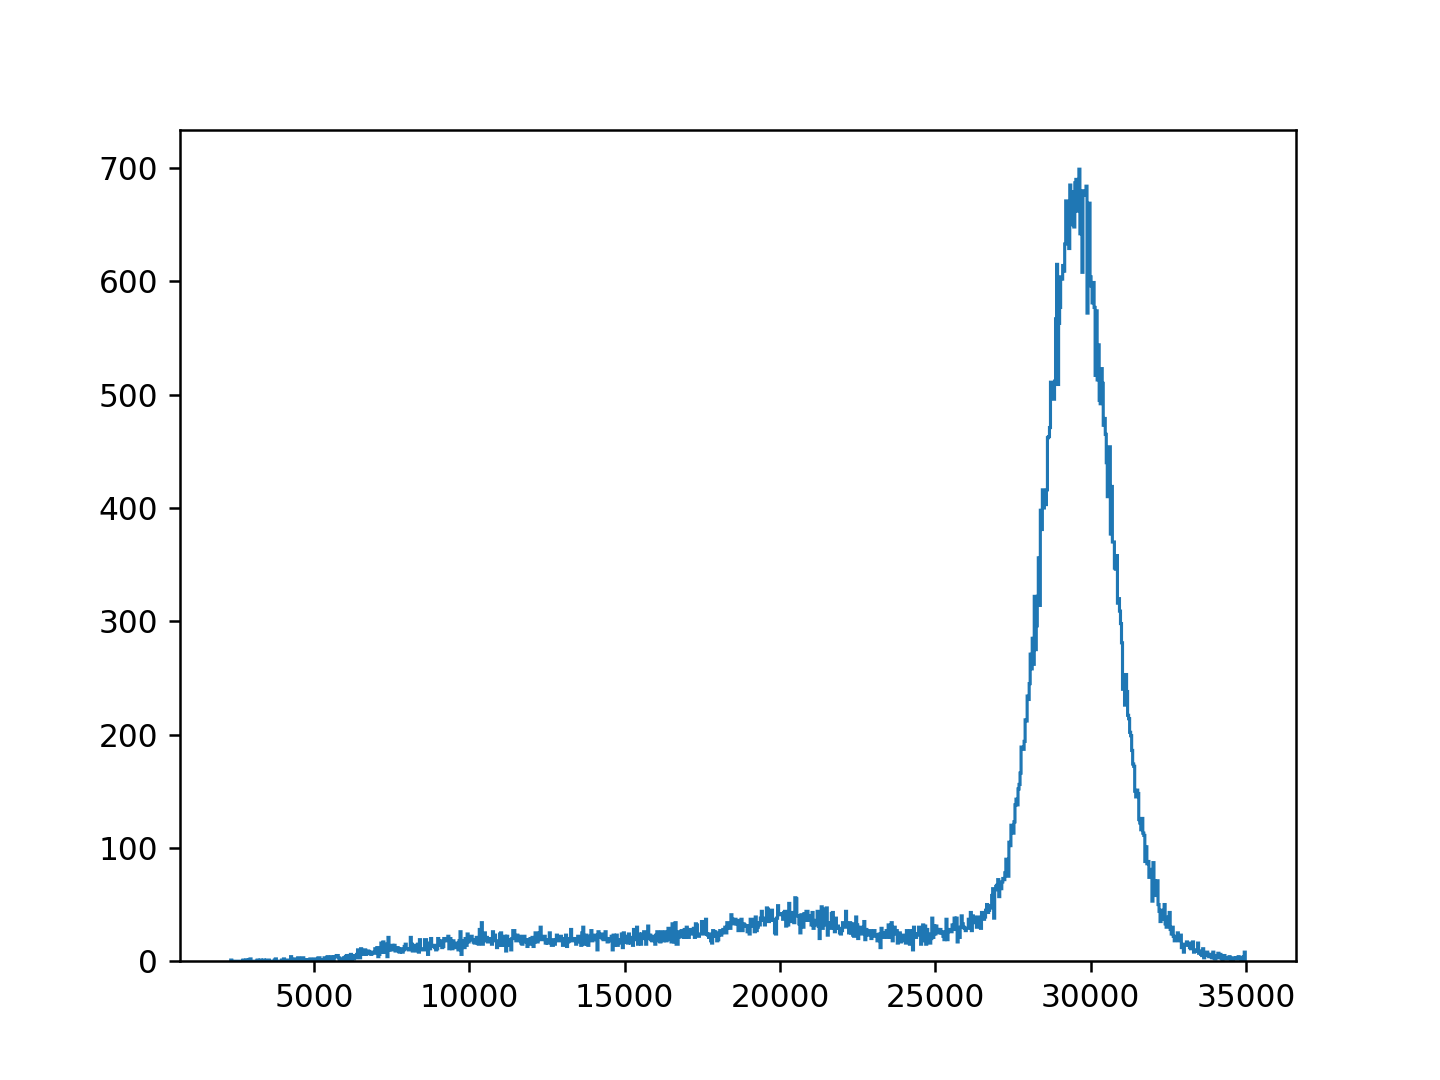

In [130]:
channels=np.array(channels)
plt.figure("Spectrum")
mask=channels<35000
channels=channels[mask]
histogram=plt.hist(channels,bins=1000,histtype='step')
hist_values=histogram[0]
hist_bins=histogram[1]
hist_bins=0.5*(hist_bins[1:]+hist_bins[:-1])

{'prominences': array([106., 699.]), 'left_bases': array([108, 108], dtype=int64), 'right_bases': array([815, 996], dtype=int64)}
FWHM:         2459.0174425380187
Peak Channel: 29584.06321372498
Peak Height:  1675837.9496346016
Slope:        0.002470049406006134


<IPython.core.display.Javascript object>


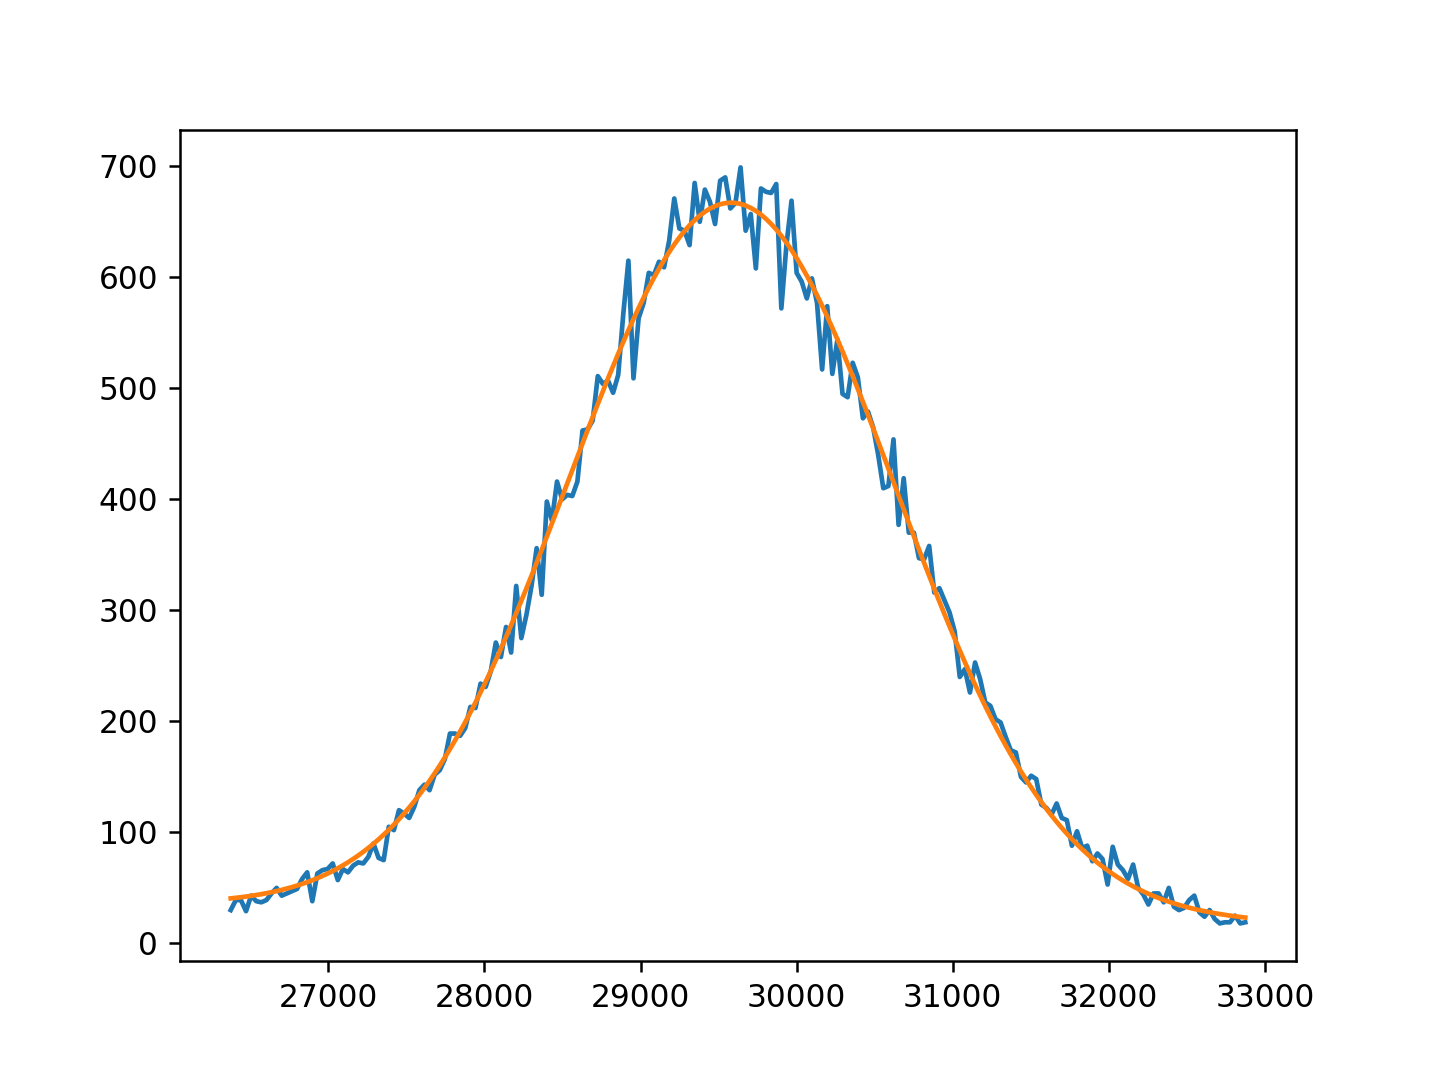

FWHM (keV):   55.000282752658826


In [134]:
peaks,prominences=find_peaks(hist_values,prominence=100)
print(prominences)
peak_index=peaks[np.argmax(prominences['prominences'])]
peak_channel=hist_bins[peak_index]

values_to_fit=hist_values[peak_index-100:peak_index+100]
bins_to_fit=hist_bins[peak_index-100:peak_index+100]

def gauss(x,fwhm,mu,magnitude,slope):
    sigma=fwhm/2.355
    return magnitude/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(x-mu)**2/sigma**2)-slope*x+100
popt,_=curve_fit(gauss,bins_to_fit,values_to_fit,p0=[2500,peak_channel,hist_values[peak_index],0])
print('FWHM:         '+str(np.abs(popt[0])))
print('Peak Channel: '+str(np.abs(popt[1])))
print('Peak Height:  '+str(np.abs(popt[2])))
print('Slope:        '+str(popt[3]))

plt.figure("Check Fit")
plt.plot(bins_to_fit,values_to_fit)
plt.plot(bins_to_fit,gauss(bins_to_fit,*popt))

energy_calib=[0,661.7] # for cs-137
channel_calib=[0,np.abs(popt[1])]
coeff=np.polyfit(channel_calib,energy_calib,1)
print('FWHM (keV):   '+str(coeff[0]*np.abs(popt[0])))




In [102]:
l=[75,81,82,84,87,90,93,96]
k=[25,25,25,25,25,25,25,25]
fwhm=[57.21,56.46,56.38,56.21,55.93,55.68,55.44,55.25]

[0.02167589 0.        ]


<IPython.core.display.Javascript object>


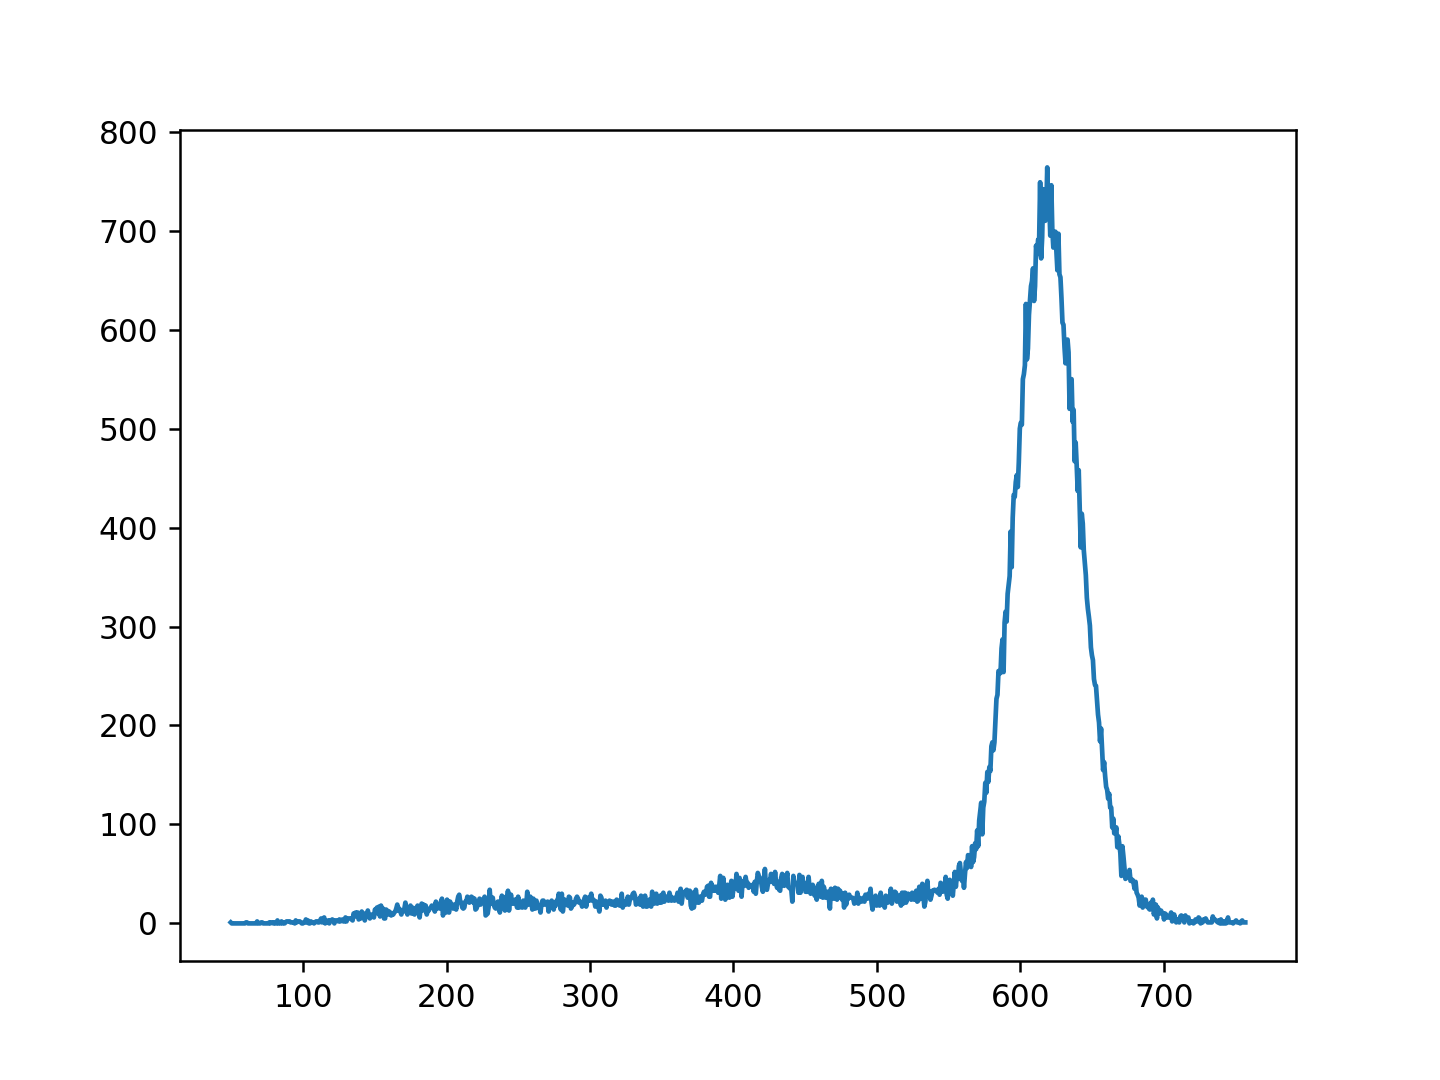

In [103]:
energies=hist_bins*coeff[0]+coeff[1]
plt.figure("Calibrated Spectrum")
plt.plot(energies,hist_values)

(72402, 200)
(72402,)


<IPython.core.display.Javascript object>


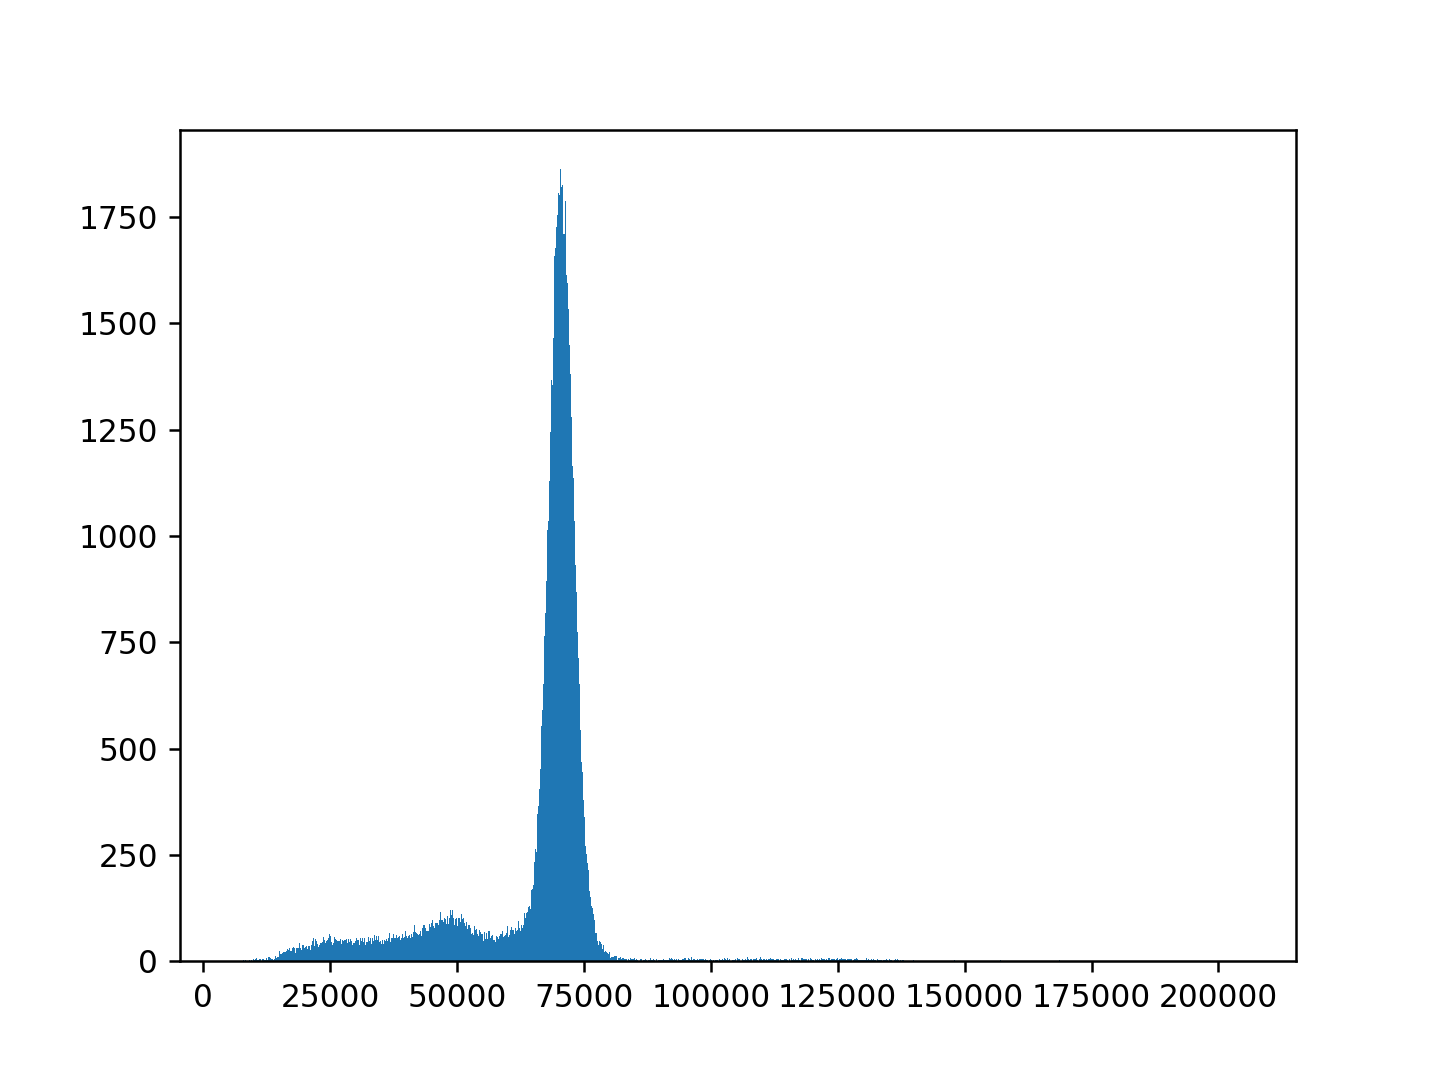

In [146]:
print(np.shape(data_to_use))
summed_channels=np.sum(data_to_use,axis=1)
print(np.shape(summed_channels))
plt.figure("Summed channels")
shistogram=plt.hist(summed_channels,bins=1000)
shist_values=shistogram[0]
shist_bins=shistogram[1]
schannels=[0,70421]
senergies=[0,661.7]
coeff=np.polyfit(schannels,senergies,1)
shist_bins=0.5*(shist_bins[1:]+shist_bins[:-1])
energies=shist_bins*coeff[0]+coeff[1]

<IPython.core.display.Javascript object>


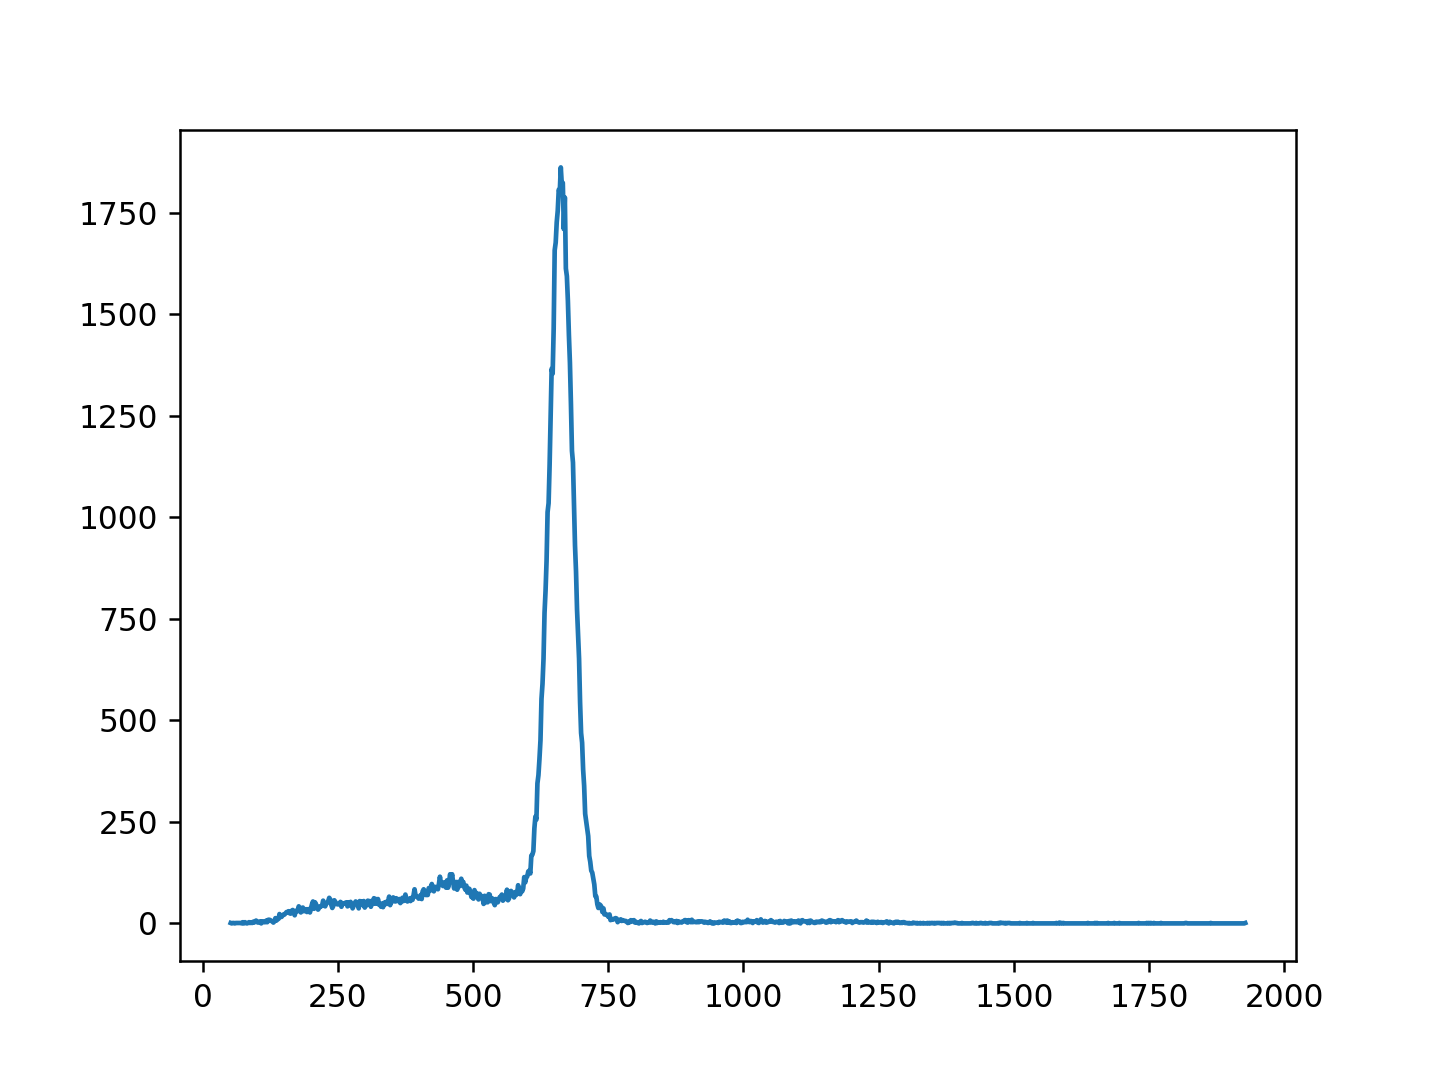

In [147]:
plt.figure("sum energy spectrum")
ehistogram=plt.plot(energies,shist_values)